In [1]:
# import standard modules and DCTR
import sys
import numpy as np
import math
import tensorflow as tf

# import DCTR
path_to_DCTR = '/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/' # modify as needed
sys.path.append(path_to_DCTR)
import DCTR

# make sure GPU usage is enabled
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# TODO: 


# Use only first Jet Particle to train
    # and try to make first Jet Particle into two and reweigh
    
    # with and without tt-pair
        # set mass = 0 for jet particles
        
# use new POWHEG events



# add reweighted uncertainty. mutliply with sqrt(sum(wgt^2)) in each bin


# compare to weights calculated from pT histograms bins



In [34]:
from importlib import reload
reload(DCTR)


<module 'DCTR' from '/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py'>

# load data

In [2]:
# Load Datasets: MiNNLO: X1 | POWHEG hvq: X0
# all particles arrays

X0_test = []
# POWHEG hvq
# args: filePath, i=number of particles to load
X0_test = DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/converted_lhe.npz', i=3)
print('POWHEG hvq X0_test.shape: '+str(X0_test.shape))

X1_test = []
# MiNNLO
X1_test = DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/converted_lhe.npz', i=3) # i=number of particles to load
print('MiNNLO     X1_test.shape: '+str(X1_test.shape))


POWHEG hvq X0_test.shape: (29605180, 3, 9)
MiNNLO     X1_test.shape: (9553938, 3, 9)


In [3]:
# Load pre-normed Datasets: MiNNLO: X1 | POWHEG hvq: X0
# only contain tt-pair every event has order: 
# tt-pair, top, anti-top

# every particle has arguments: 
# [pt, rapidity, phi, mass, eta, E, PID, w, theta]
# [0 , 1       , 2  , 3   , 4  , 5, 6  , 7, 8    ]


X0_nrm = []
X1_nrm = []

# POWHEG hvq
X0_nrm = DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/normed_lhe.npz')
print('POWHEG hvq all particles X0.shape: '+str(X0_nrm.shape))

# MiNNLO
X1_nrm = DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/normed_lhe.npz')
print('MiNNLO all particles X1.shape: '+str(X1_nrm.shape))


POWHEG hvq all particles X0.shape: (29605180, 3, 9)
MiNNLO all particles X1.shape: (9553938, 3, 9)


In [4]:
# delete eta (pseudorpaidity) because neural network was too good at classifiying
X0_nrm = np.delete(X0_nrm, 4, -1)
X1_nrm = np.delete(X1_nrm, 4, -1)


In [5]:
# get normalized event generator weights
X0_nrm_wgt = np.array(X0_nrm[:, 0, 6], copy=True) # would be arg 7, but we removed eta above
X1_nrm_wgt = np.array(X1_nrm[:, 0, 6], copy=True)


# Neural Positive Reweighter

In [ ]:
# neural positive resampling
# uses neural network to distinguish between identical copies of the events,
# where only difference is the original (incl. negative) weights and all weights = 1
# -> likelihood ratio: all positive weights
# here: every |wgt| = 1 -> no need to find optimal K | arXiv:2007.11586 neural reweighing


In [7]:
# neural positive reweigher for MiNNLO X1

from energyflow.utils import to_categorical # used to create one-hot encoding
from sklearn.model_selection import train_test_split # used to split training dataset into train and validation sets

x = np.concatenate([X1_nrm, X1_nrm]) # two identical copies
wgt = np.concatenate([X1_nrm_wgt, np.ones(len(X1_nrm_wgt))]) # original wgts as is and all = 1 

y = np.concatenate([np.ones(len(X1_nrm)),np.zeros(len(X1_nrm))]) # identifier
y = to_categorical(y, num_classes=2) # encode y as one hot

# split x, y, wgt into random training and validation datasets
X_rwgt_train, X_rwgt_val, Y_rwgt_train, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val = train_test_split(x[...,:-2], y, wgt, test_size=0.3) 

del x
del y
del wgt


In [ ]:
# setup neural positive reweigher
# default setup_nn() args:
# input_dim=7, Phi_sizes = (100,100,128), F_sizes = (100,100,100),
# loss = 'cce', foc_gamma=2, dropout=0.0, l2_reg=0.0, learning_rate=0.001,
# patience=10, use_scheduler=True, monitor='val_loss', mode='min', 
# savePath=currentPath, saveLabel='DCTR_training', summary=False):

# suppots 'mse', 'focal' and 'cce' losses. default 'cce' is used if string isn't either 'mse' or 'focal'
# returns neural network and callbacks

pos_rwgt, cb = DCTR.setup_nn(input_dim=2, Phi_sizes=(10,10,10)) # compiling model with different sizes clears weights

pos_rwgt, cb = DCTR.setup_nn(input_dim=6, patience=20, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_4x', loss='mse')


In [ ]:
# train neural network
# train() necessary args:
# dctr, callbacks, X_train, Y_train, X_val, Y_val

# train() default args:
# wgt_train=1.0, wgt_val=1.0, epochs=80, batch_size=8192, savePath=currentPath, saveLabel='DCTR_training'):

DCTR.train(pos_rwgt, cb, X_rwgt_train, Y_rwgt_train, X_rwgt_val, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val, batch_size=8192*4, epochs=500, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_4x')


In [ ]:
pos_rwgt, cb = DCTR.setup_nn(input_dim=2, Phi_sizes=(10,10,10))
pos_rwgt, cb = DCTR.setup_nn(input_dim=6, patience=20, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_8x', loss='mse', learning_rate=0.0005)
DCTR.train(pos_rwgt, cb, X_rwgt_train, Y_rwgt_train, X_rwgt_val, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val, batch_size=8192*8, epochs=500, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_8x')


In [ ]:
pos_rwgt, cb = DCTR.setup_nn(input_dim=2, Phi_sizes=(10,10,10))
pos_rwgt, cb = DCTR.setup_nn(input_dim=6, patience=20, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_16x', loss='mse', learning_rate=0.0005)
DCTR.train(pos_rwgt, cb, X_rwgt_train, Y_rwgt_train, X_rwgt_val, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val, batch_size=8192*16, epochs=500, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_16x')


In [ ]:
pos_rwgt, cb = DCTR.setup_nn(input_dim=2, Phi_sizes=(10,10,10))
pos_rwgt, cb = DCTR.setup_nn(input_dim=6, patience=20, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_32x', loss='mse', learning_rate=0.0005)
DCTR.train(pos_rwgt, cb, X_rwgt_train, Y_rwgt_train, X_rwgt_val, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val, batch_size=8192*32, epochs=500, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_32x')


In [ ]:
pos_rwgt, cb = DCTR.setup_nn(input_dim=2, Phi_sizes=(10,10,10))
pos_rwgt, cb = DCTR.setup_nn(input_dim=6, patience=20, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_64x', loss='mse', learning_rate=0.0005)
DCTR.train(pos_rwgt, cb, X_rwgt_train, Y_rwgt_train, X_rwgt_val, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val, batch_size=8192*64, epochs=500, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_64x')


In [ ]:
pos_rwgt, cb = DCTR.setup_nn(input_dim=2, Phi_sizes=(10,10,10))
pos_rwgt, cb = DCTR.setup_nn(input_dim=6, patience=20, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_2x', loss='mse', learning_rate=0.0005)
DCTR.train(pos_rwgt, cb, X_rwgt_train, Y_rwgt_train, X_rwgt_val, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val, batch_size=8192*2, epochs=500, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_2x')


In [ ]:
pos_rwgt, cb = DCTR.setup_nn(input_dim=2, Phi_sizes=(10,10,10))
pos_rwgt, cb = DCTR.setup_nn(input_dim=6, patience=20, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_1x', loss='mse', learning_rate=0.0005)
DCTR.train(pos_rwgt, cb, X_rwgt_train, Y_rwgt_train, X_rwgt_val, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val, batch_size=8192*1, epochs=500, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_1x')


In [ ]:
pos_rwgt, cb = DCTR.setup_nn(input_dim=2, Phi_sizes=(10,10,10))
pos_rwgt, cb = DCTR.setup_nn(input_dim=6, patience=20, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_0.5x', loss='mse', learning_rate=0.0005)
DCTR.train(pos_rwgt, cb, X_rwgt_train, Y_rwgt_train, X_rwgt_val, Y_rwgt_val, wgt_rwgt_train, wgt_rwgt_val, batch_size=4096, epochs=500, saveLabel='DCTR_X1_MiNNLO_positive_reweighing_0.5x')


In [6]:
pos_rwgt, _ = DCTR.setup_nn(input_dim=6)

with tf.device('/gpu:0'): # sometimes gave me errors when done on GPU b/c trying to convert X1 to a tensor requires too much memory
    
    pos_rwgt.load_weights('DCTR_X1_MiNNLO_positive_reweighing_0.5x.h5')
    rwgt_pred = pos_rwgt.predict(X1_nrm[...,:-2], batch_size = 8192*8, verbose=1) # without wgt and theta parameters, they are the last two parameters
    X1_pos_wgt_05x = rwgt_pred[:,1]/rwgt_pred[:,0]
    X1_pos_wgt_05x /= np.mean(X1_pos_wgt_05x) # adjust weights so that mean is 1
    
    pos_rwgt.load_weights('DCTR_X1_MiNNLO_positive_reweighing_1x.h5')
    rwgt_pred = pos_rwgt.predict(X1_nrm[...,:-2], batch_size = 8192*8, verbose=1) # without wgt and theta parameters, they are the last two parameters
    X1_pos_wgt_1x = rwgt_pred[:,1]/rwgt_pred[:,0]
    X1_pos_wgt_1x /= np.mean(X1_pos_wgt_1x) # adjust weights so that mean is 1
    
    pos_rwgt.load_weights('DCTR_X1_MiNNLO_positive_reweighing_2x.h5')
    rwgt_pred = pos_rwgt.predict(X1_nrm[...,:-2], batch_size = 8192*8, verbose=1) # without wgt and theta parameters, they are the last two parameters
    X1_pos_wgt_2x = rwgt_pred[:,1]/rwgt_pred[:,0]
    X1_pos_wgt_2x /= np.mean(X1_pos_wgt_2x) # adjust weights so that mean is 1
    
    pos_rwgt.load_weights('DCTR_X1_MiNNLO_positive_reweighing_4x.h5')
    rwgt_pred = pos_rwgt.predict(X1_nrm[...,:-2], batch_size = 8192*8, verbose=1) # without wgt and theta parameters, they are the last two parameters
    X1_pos_wgt_4x = rwgt_pred[:,1]/rwgt_pred[:,0]
    X1_pos_wgt_4x /= np.mean(X1_pos_wgt_4x) # adjust weights so that mean is 1

    pos_rwgt.load_weights('DCTR_X1_MiNNLO_positive_reweighing_8x.h5')
    rwgt_pred = pos_rwgt.predict(X1_nrm[...,:-2], batch_size = 8192*8, verbose=1) # without wgt and theta parameters, they are the last two parameters
    X1_pos_wgt_8x = rwgt_pred[:,1]/rwgt_pred[:,0]
    X1_pos_wgt_8x /= np.mean(X1_pos_wgt_8x) # adjust weights so that mean is 1
    
    pos_rwgt.load_weights('DCTR_X1_MiNNLO_positive_reweighing_16x.h5')
    rwgt_pred = pos_rwgt.predict(X1_nrm[...,:-2], batch_size = 8192*8, verbose=1) # without wgt and theta parameters, they are the last two parameters
    X1_pos_wgt_16x = rwgt_pred[:,1]/rwgt_pred[:,0]
    X1_pos_wgt_16x /= np.mean(X1_pos_wgt_16x) # adjust weights so that mean is 1
    
    pos_rwgt.load_weights('DCTR_X1_MiNNLO_positive_reweighing_32x.h5')
    rwgt_pred = pos_rwgt.predict(X1_nrm[...,:-2], batch_size = 8192*8, verbose=1) # without wgt and theta parameters, they are the last two parameters
    X1_pos_wgt_32x = rwgt_pred[:,1]/rwgt_pred[:,0]
    X1_pos_wgt_32x /= np.mean(X1_pos_wgt_32x) # adjust weights so that mean is 1
    
    pos_rwgt.load_weights('DCTR_X1_MiNNLO_positive_reweighing_64x.h5')
    rwgt_pred = pos_rwgt.predict(X1_nrm[...,:-2], batch_size = 8192*8, verbose=1) # without wgt and theta parameters, they are the last two parameters
    X1_pos_wgt_64x = rwgt_pred[:,1]/rwgt_pred[:,0]
    X1_pos_wgt_64x /= np.mean(X1_pos_wgt_64x) # adjust weights so that mean is 1
    

146/146 [==============================] - 1s 9ms/step


In [7]:
args = [(X1_nrm, X1_nrm_wgt, 'MiNNLO'),
        #(X1_nrm, [1]*len(X1_nrm), 'all weights = 1'),
        (X1_nrm, X1_pos_wgt_05x, 'batch: 0.5*8192'),
        (X1_nrm, X1_pos_wgt_1x, 'batch: 1*8192'),
        (X1_nrm, X1_pos_wgt_2x, 'batch: 2*8192'),
        (X1_nrm, X1_pos_wgt_4x, 'batch: 4*8192')]
        

plot_ratio(args, arg_index = 0, part_index = 0, start=-5, stop=3.5)


NameError: name 'plot_ratio' is not defined

In [ ]:
args = [(X1_nrm, X1_nrm_wgt, 'MiNNLO'),
        #(X1_nrm, [1]*len(X1_nrm), 'all weights = 1'),
        (X1_nrm, X1_pos_wgt_8x, 'batch: 8*8192'),
        (X1_nrm, X1_pos_wgt_16x, 'batch: 16*8192'),
        (X1_nrm, X1_pos_wgt_32x, 'batch: 32*8192'),
        (X1_nrm, X1_pos_wgt_64x, 'batch: 64*8192')]

plot_any_ratio(args, arg_index = 0, part_index = 0, start=-5, stop=3.5)



In [ ]:
# load neural positive resampler training
# pos_rwgt, _ = DCTR.setup_nn(input_dim=6)
pos_rwgt.load_weights('DCTR_X1_MiNNLO_positive_reweighing_16x.h5') # trained previously

# make prediction 
with tf.device('/cpu:0'): # sometimes gave me errors when done on GPU b/c trying to convert X1 to a tensor requires too much memory
    rwgt_pred = pos_rwgt.predict(X1_nrm[...,:-2], batch_size = 8192*64, verbose=1) # without wgt and theta parameters, they are the last two parameters

# positive weights from likelihood ratio
X1_pos_wgt = rwgt_pred[:,1]/rwgt_pred[:,0]
X1_pos_wgt /= np.mean(X1_pos_wgt) # adjust weights so that mean is 1

# plot comparison of generator weights and all positive weights
DCTR.plot_weights(X1_nrm_wgt, X1_pos_wgt, start=-1.1, stop=1.5, div=55)


In [ ]:
# plot validation graph
DCTR.plot_3_ratio(X1_nrm, X1_nrm, X1_nrm,
                  arg_index = 0, part_index=0,
                  X0_wgt = 1, X1_wgt = X1_nrm_wgt, X2_wgt = X1_pos_wgt,
                  X0_label = 'all weights = 1', X1_label = 'original event generator weights', X2_label = 'neural positive reweigted',
                  start=-5, stop=3.5, div = 51, ratio_ylim=[0.9,1.1])


In [ ]:
# give new positive weights to X1 MiNNLO dataset
X1_nrm[...,6] = X1_pos_wgt[:, np.newaxis] # would be arg 7, but we removed eta above

# clear reweighing training arrays from memory
del X_rwgt_train
del X_rwgt_val
del Y_rwgt_train
del Y_rwgt_val
del wgt_rwgt_train
del wgt_rwgt_val


# Preparing Datasets for Training

In [19]:
X0_nrm[...,6] = 1 # setting all POWGEG X0 weights = 1


In [20]:
# create training datasets
# POWHEG has many more events than MiNNLO -> use multiple copies of MiNNLO (two b/c RAM limitations)
# trim_datasets(X, Y, shuffle=True) returns the two arrays trimmed to the length of the shorter of the two
# if shuffle =+ True: uses np.rng to shuffle order of events
X0, X1 = DCTR.trim_datasets(X0_nrm, np.concatenate((X1_nrm, X1_nrm)))

print('POWHEG hvq all particles X0.shape: '+str(X0.shape))
print('MiNNLO all particles X1.shape: '+str(X1.shape))


POWHEG hvq all particles X0.shape: (19107876, 3, 8)
MiNNLO all particles X1.shape: (19107876, 3, 8)


In [21]:
# prep arrays for the neural network

# prep_arrays() necessary args:
# X0, X1
# prep_arrays() default args:
# val=0.15, shuffle=True, use_class_weights=False

# strips theta parameter from datasets and creates Y classifier arrays
# strips wgts from datasets and creates wgt arrays | if use_class_weights==True: -> give over represented dataset smaller weights 
# splits arrays into training and validation datasets accroding to val

X_train, X_val, Y_train, Y_val, wgt_train, wgt_val = DCTR.prep_arrays(X0, X1, val=0.2)

# clear previous temp arrays from memory
X0 = []
X1 = []



# train DCTR neural network

### using MSE and negative event_weights

Epoch 1/500
234/234 [==============================] - ETA: 0s - loss: 0.2122 - acc: 0.5608
Epoch 1: val_loss improved from inf to 0.21222, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_mse_16x.h5
234/234 [==============================] - 14s 48ms/step - loss: 0.2122 - acc: 0.5608 - val_loss: 0.2122 - val_acc: 0.5577 - lr: 0.0010
Epoch 2/500
233/234 [============================>.] - ETA: 0s - loss: 0.2121 - acc: 0.5609
Epoch 2: val_loss improved from 0.21222 to 0.21219, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_mse_16x.h5
234/234 [==============================] - 11s 46ms/step - loss: 0.2121 - acc: 0.5609 - val_loss: 0.2122 - val_acc: 0.5646 - lr: 0.0010
Epoch 3/500
233/234 [============================>.] - ETA: 0s - loss: 0.2121 - acc: 0.5610
Epoch 3: val_loss did not improve from 0.21219
234/234 [==============================] - 11s 45ms/step - loss: 0.2121 - acc: 0.5610 - val_loss:

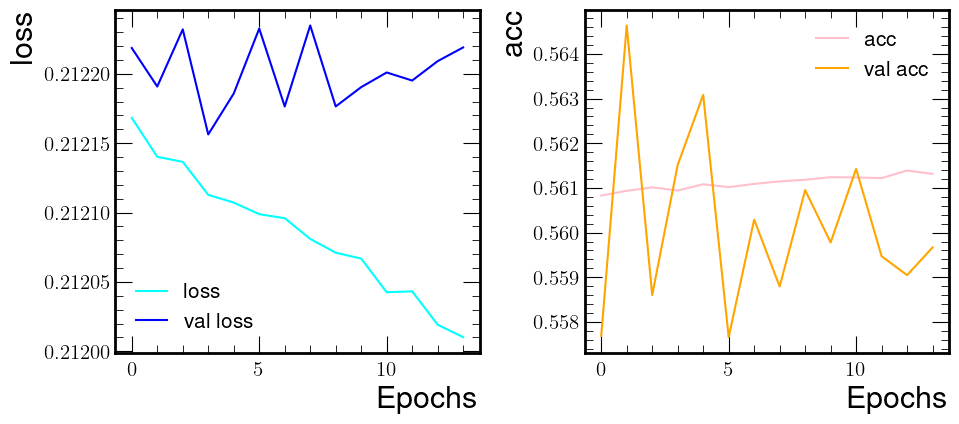

In [10]:
# MSE 16x | 7.17G VRAM
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=10, learning_rate=0.001, saveLabel='DCTR_training_mse_16x', loss='mse')
dctr.load_weights('DCTR_training_mse_16x.h5')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*16, saveLabel='DCTR_training_mse_16x')


Epoch 1/500
116/117 [============================>.] - ETA: 0s - loss: 0.2267 - acc: 0.5343
Epoch 1: val_loss improved from inf to 0.21659, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_mse_32x.h5
117/117 [==============================] - 13s 97ms/step - loss: 0.2266 - acc: 0.5343 - val_loss: 0.2166 - val_acc: 0.5483 - lr: 0.0010
Epoch 2/500
116/117 [============================>.] - ETA: 0s - loss: 0.2158 - acc: 0.5517
Epoch 2: val_loss improved from 0.21659 to 0.21505, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_mse_32x.h5
117/117 [==============================] - 11s 98ms/step - loss: 0.2158 - acc: 0.5516 - val_loss: 0.2151 - val_acc: 0.5581 - lr: 0.0010
Epoch 3/500
116/117 [============================>.] - ETA: 0s - loss: 0.2147 - acc: 0.5569
Epoch 3: val_loss improved from 0.21505 to 0.21438, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training

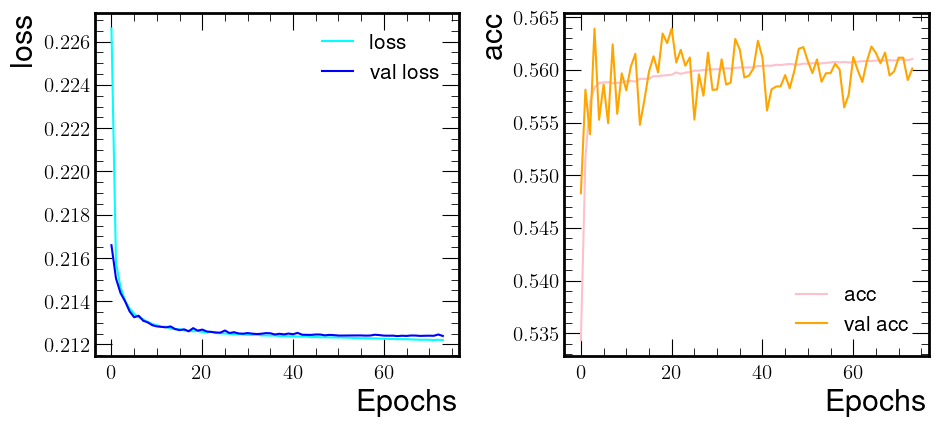

In [22]:
# MSE 32x
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=10, learning_rate=0.001, saveLabel='DCTR_training_mse_32x', loss='mse')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*32, saveLabel='DCTR_training_mse_32x')


Epoch 1/500
58/59 [============================>.] - ETA: 0s - loss: 0.2142 - acc: 0.5543
Epoch 1: val_loss improved from inf to 0.21262, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_mse_64x.h5
59/59 [==============================] - 13s 195ms/step - loss: 0.2142 - acc: 0.5544 - val_loss: 0.2126 - val_acc: 0.5609 - lr: 0.0010
Epoch 2/500
58/59 [============================>.] - ETA: 0s - loss: 0.2125 - acc: 0.5596
Epoch 2: val_loss improved from 0.21262 to 0.21241, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_mse_64x.h5
59/59 [==============================] - 11s 192ms/step - loss: 0.2125 - acc: 0.5596 - val_loss: 0.2124 - val_acc: 0.5607 - lr: 0.0010
Epoch 3/500
59/59 [==============================] - ETA: 0s - loss: 0.2124 - acc: 0.5601
Epoch 3: val_loss improved from 0.21241 to 0.21235, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_mse_64x

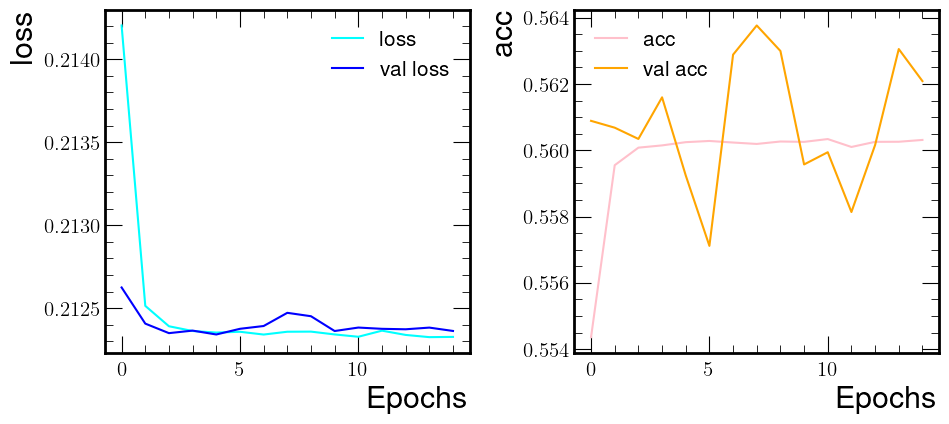

In [12]:
# MSE 64x
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=10, learning_rate=0.001, saveLabel='DCTR_training_mse_64x', loss='mse')
dctr.load_weights('DCTR_training_mse_64x.h5')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*64, saveLabel='DCTR_training_mse_64x')


### using CCE and negative event_weights

Epoch 1/500
234/234 [==============================] - ETA: 0s - loss: 0.5908 - acc: 0.5599
Epoch 1: val_loss improved from inf to 0.59266, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_cce_16x.h5
234/234 [==============================] - 12s 47ms/step - loss: 0.5908 - acc: 0.5599 - val_loss: 0.5927 - val_acc: 0.5548 - lr: 0.0010
Epoch 2/500
233/234 [============================>.] - ETA: 0s - loss: 0.5900 - acc: 0.5596
Epoch 2: val_loss improved from 0.59266 to 0.59221, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_cce_16x.h5
234/234 [==============================] - 11s 45ms/step - loss: 0.5900 - acc: 0.5596 - val_loss: 0.5922 - val_acc: 0.5565 - lr: 0.0010
Epoch 3/500
233/234 [============================>.] - ETA: 0s - loss: 0.5902 - acc: 0.5594
Epoch 3: val_loss did not improve from 0.59221
234/234 [==============================] - 11s 46ms/step - loss: 0.5902 - acc: 0.5594 - val_loss:

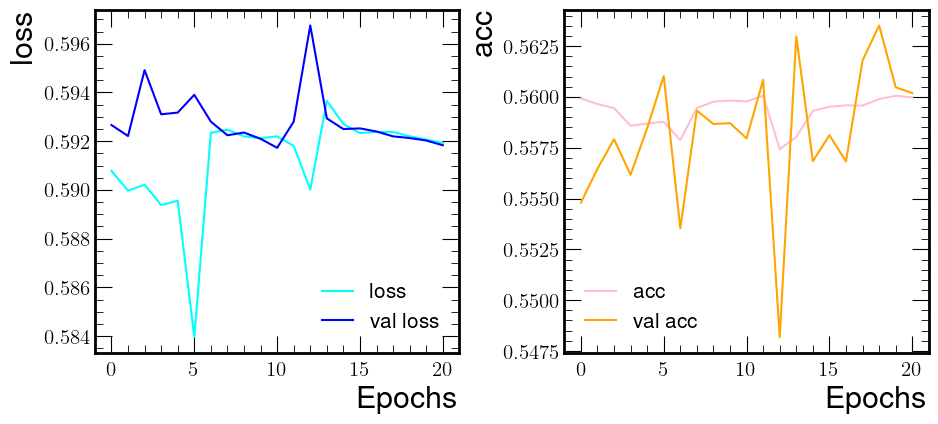

In [13]:
# CCE 16x | 7.17G VRAM
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=10, learning_rate=0.001, saveLabel='DCTR_training_cce_16x', loss='cce')
dctr.load_weights('DCTR_training_cce_16x.h5')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*16, saveLabel='DCTR_training_cce_16x')


Epoch 1/500
116/117 [============================>.] - ETA: 0s - loss: 0.5922 - acc: 0.5595
Epoch 1: val_loss improved from inf to 0.59203, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_cce_32x.h5
117/117 [==============================] - 13s 98ms/step - loss: 0.5921 - acc: 0.5595 - val_loss: 0.5920 - val_acc: 0.5599 - lr: 0.0010
Epoch 2/500
117/117 [==============================] - ETA: 0s - loss: 0.5921 - acc: 0.5598
Epoch 2: val_loss did not improve from 0.59203
117/117 [==============================] - 11s 97ms/step - loss: 0.5921 - acc: 0.5598 - val_loss: 0.5924 - val_acc: 0.5611 - lr: 0.0010
Epoch 3/500
116/117 [============================>.] - ETA: 0s - loss: 0.5917 - acc: 0.5601
Epoch 3: val_loss did not improve from 0.59203
117/117 [==============================] - 11s 97ms/step - loss: 0.5917 - acc: 0.5601 - val_loss: 0.5930 - val_acc: 0.5580 - lr: 0.0010
Epoch 4/500
117/117 [==============================] - ETA: 0s - loss:

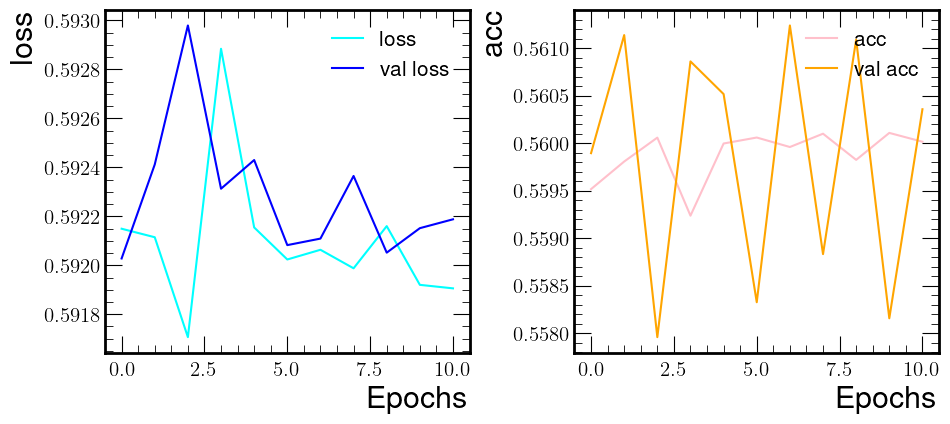

In [14]:
# CCE 32x
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=10, learning_rate=0.001, saveLabel='DCTR_training_cce_32x', loss='cce')
dctr.load_weights('DCTR_training_cce_32x.h5')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*32, saveLabel='DCTR_training_cce_32x')


Epoch 1/500
58/59 [============================>.] - ETA: 0s - loss: 0.5064 - acc: 0.5231
Epoch 1: val_loss improved from inf to 0.17490, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_mse_64x.h5
59/59 [==============================] - 13s 194ms/step - loss: 0.5043 - acc: 0.5232 - val_loss: 0.1749 - val_acc: 0.5342 - lr: 0.0010
Epoch 2/500
58/59 [============================>.] - ETA: 0s - loss: 0.3117 - acc: 0.5386
Epoch 2: val_loss did not improve from 0.17490
59/59 [==============================] - 11s 192ms/step - loss: 0.3156 - acc: 0.5386 - val_loss: 0.4576 - val_acc: 0.5473 - lr: 0.0010
Epoch 3/500
58/59 [============================>.] - ETA: 0s - loss: 0.4706 - acc: 0.5472
Epoch 3: val_loss did not improve from 0.17490
59/59 [==============================] - 11s 192ms/step - loss: 0.4708 - acc: 0.5472 - val_loss: 0.5829 - val_acc: 0.5479 - lr: 0.0010
Epoch 4/500
58/59 [============================>.] - ETA: 0s - loss: 0.3947 - a

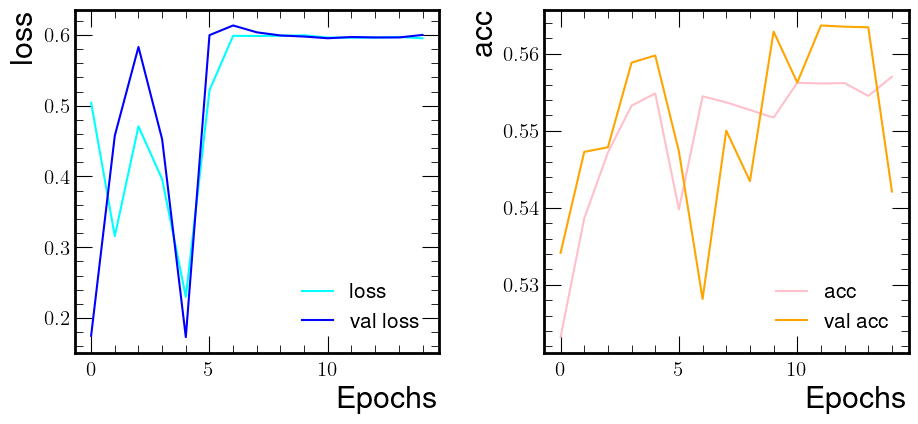

In [15]:
# CCE 64x
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=10, learning_rate=0.001, saveLabel='DCTR_training_mse_64x', loss='cce')
dctr.load_weights('DCTR_training_cce_64x.h5')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*64, saveLabel='DCTR_training_cce_64x')


### neural positive reweighted MiNNLO | CCE

In [6]:
# load neural positive resampler training
pos_rwgt, _ = DCTR.setup_nn(input_dim=6)
pos_rwgt.load_weights('DCTR_X1_MiNNLO_positive_reweighing_4x.h5') # trained previously

# make prediction 
with tf.device('/cpu:0'): # sometimes gave me errors when done on GPU b/c trying to convert X1 to a tensor requires too much memory
    rwgt_pred = pos_rwgt.predict(X1_nrm[...,:-2], batch_size = 8192*16, verbose=1) # without wgt and theta parameters, they are the last two parameters

# positive weights from likelihood ratio
X1_pos_wgt = rwgt_pred[:,1]/rwgt_pred[:,0]
X1_pos_wgt /= np.mean(X1_pos_wgt) # adjust weights so that mean is 1

# give X1 new wgt
X1_nrm[...,6] = X1_pos_wgt[:, np.newaxis] # would be arg 7, but we removed eta above


73/73 [==============================] - 11s 149ms/step


In [7]:
# prep training dataset
X0, X1 = DCTR.trim_datasets(X0_nrm, np.concatenate((X1_nrm, X1_nrm)))

X_train, X_val, Y_train, Y_val, wgt_train, wgt_val = DCTR.prep_arrays(X0, X1, val=0.2)

# clear previous temp arrays from memory
X0 = []
X1 = []

### using CCE and neural positive weights

Epoch 1/500
233/234 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.5367
Epoch 1: val_loss improved from inf to 0.66887, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_16x.h5
234/234 [==============================] - 14s 47ms/step - loss: 0.6931 - acc: 0.5368 - val_loss: 0.6689 - val_acc: 0.5479 - lr: 0.0010
Epoch 2/500
233/234 [============================>.] - ETA: 0s - loss: 0.6664 - acc: 0.5511
Epoch 2: val_loss improved from 0.66887 to 0.66441, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_16x.h5
234/234 [==============================] - 11s 46ms/step - loss: 0.6664 - acc: 0.5511 - val_loss: 0.6644 - val_acc: 0.5560 - lr: 0.0010
Epoch 3/500
233/234 [============================>.] - ETA: 0s - loss: 0.6631 - acc: 0.5541
Epoch 3: val_loss improved from 0.66441 to 0.66190, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_tr

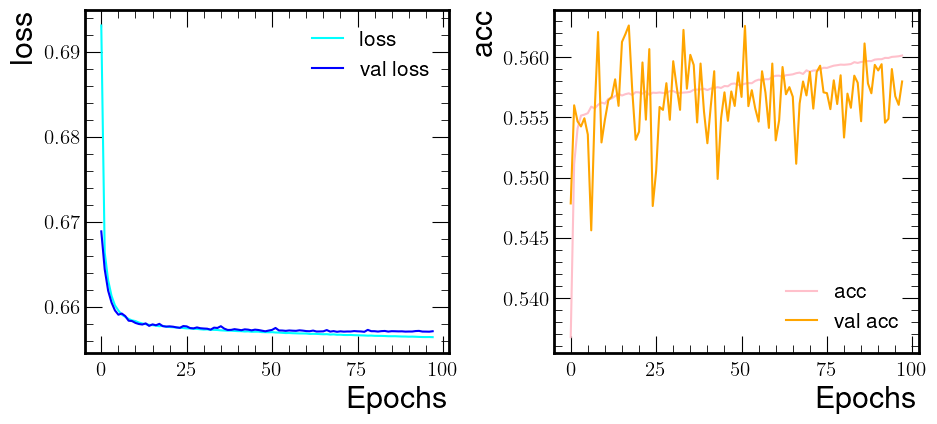

In [8]:
# CCE 16x | 7.17G VRAM
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=20, learning_rate=0.001, saveLabel='DCTR_training_np_cce_16x', loss='cce')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*16, saveLabel='DCTR_training_np_cce_16x')


Epoch 1/500
117/117 [==============================] - ETA: 0s - loss: 0.7160 - acc: 0.5336
Epoch 1: val_loss improved from inf to 0.67373, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_32x.h5
117/117 [==============================] - 13s 97ms/step - loss: 0.7160 - acc: 0.5336 - val_loss: 0.6737 - val_acc: 0.5426 - lr: 0.0010
Epoch 2/500
116/117 [============================>.] - ETA: 0s - loss: 0.6711 - acc: 0.5461
Epoch 2: val_loss improved from 0.67373 to 0.66873, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_32x.h5
117/117 [==============================] - 11s 97ms/step - loss: 0.6711 - acc: 0.5461 - val_loss: 0.6687 - val_acc: 0.5499 - lr: 0.0010
Epoch 3/500
117/117 [==============================] - ETA: 0s - loss: 0.6672 - acc: 0.5513
Epoch 3: val_loss improved from 0.66873 to 0.66578, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_tr

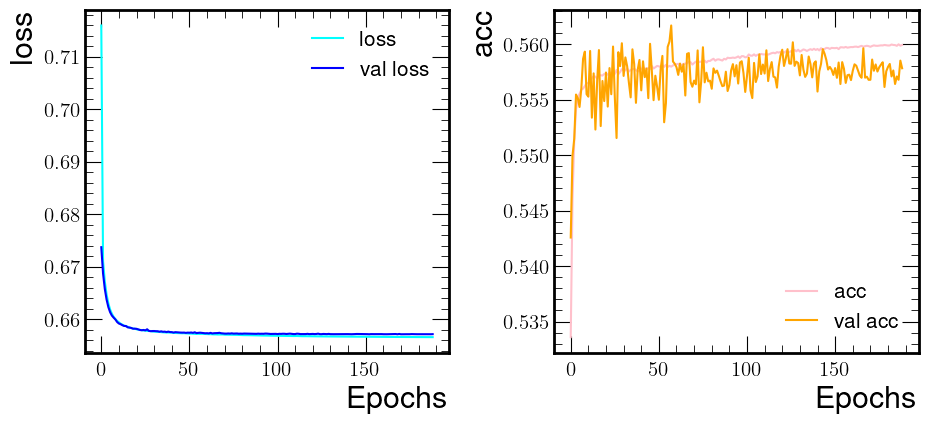

In [9]:
# CCE 32x
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=20, learning_rate=0.001, saveLabel='DCTR_training_np_cce_32x', loss='cce')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*32, saveLabel='DCTR_training_np_cce_32x')


Epoch 1/500
58/59 [============================>.] - ETA: 0s - loss: 0.7412 - acc: 0.5192
Epoch 1: val_loss improved from inf to 0.67866, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_64x.h5
59/59 [==============================] - 13s 194ms/step - loss: 0.7409 - acc: 0.5193 - val_loss: 0.6787 - val_acc: 0.5279 - lr: 0.0010
Epoch 2/500
58/59 [============================>.] - ETA: 0s - loss: 0.6753 - acc: 0.5349
Epoch 2: val_loss improved from 0.67866 to 0.67259, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_64x.h5
59/59 [==============================] - 11s 189ms/step - loss: 0.6753 - acc: 0.5349 - val_loss: 0.6726 - val_acc: 0.5400 - lr: 0.0010
Epoch 3/500
58/59 [============================>.] - ETA: 0s - loss: 0.6710 - acc: 0.5435
Epoch 3: val_loss improved from 0.67259 to 0.66955, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_n

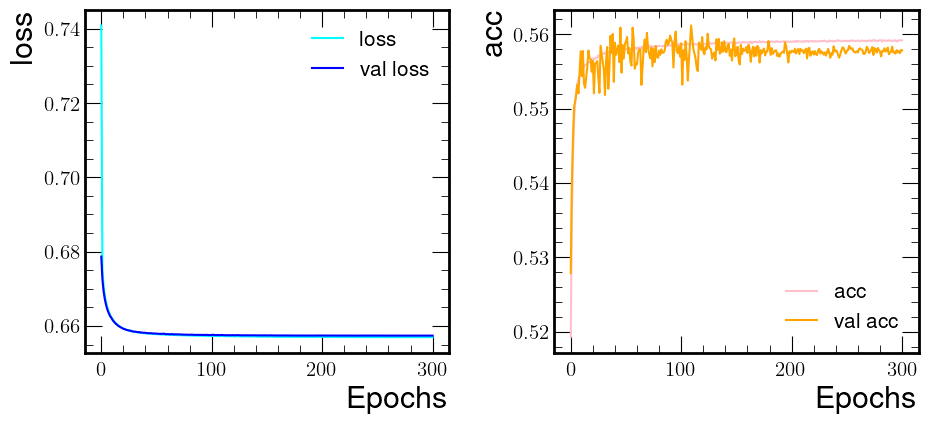

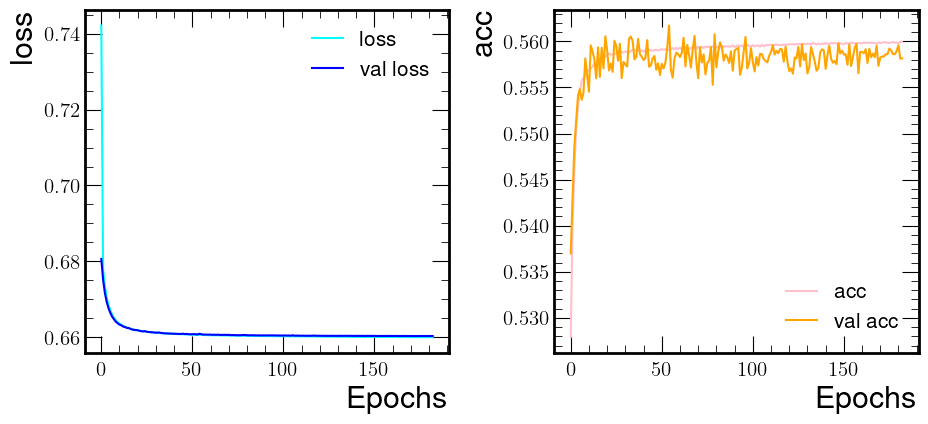

In [10]:
# CCE 64x
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=20, learning_rate=0.001, saveLabel='DCTR_training_np_cce_64x', loss='cce')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*64, saveLabel='DCTR_training_np_cce_64x')


Epoch 1/500
931/934 [============================>.] - ETA: 0s - loss: 0.6720 - acc: 0.5489
Epoch 1: val_loss improved from inf to 0.67014, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_4x.h5
934/934 [==============================] - 13s 12ms/step - loss: 0.6719 - acc: 0.5489 - val_loss: 0.6701 - val_acc: 0.5531 - lr: 0.0010
Epoch 2/500
933/934 [============================>.] - ETA: 0s - loss: 0.6604 - acc: 0.5559
Epoch 2: val_loss improved from 0.67014 to 0.66063, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_4x.h5
934/934 [==============================] - 11s 12ms/step - loss: 0.6604 - acc: 0.5559 - val_loss: 0.6606 - val_acc: 0.5443 - lr: 0.0010
Epoch 3/500
930/934 [============================>.] - ETA: 0s - loss: 0.6590 - acc: 0.5566
Epoch 3: val_loss did not improve from 0.66063
934/934 [==============================] - 11s 12ms/step - loss: 0.6590 - acc: 0.5566 - val_l

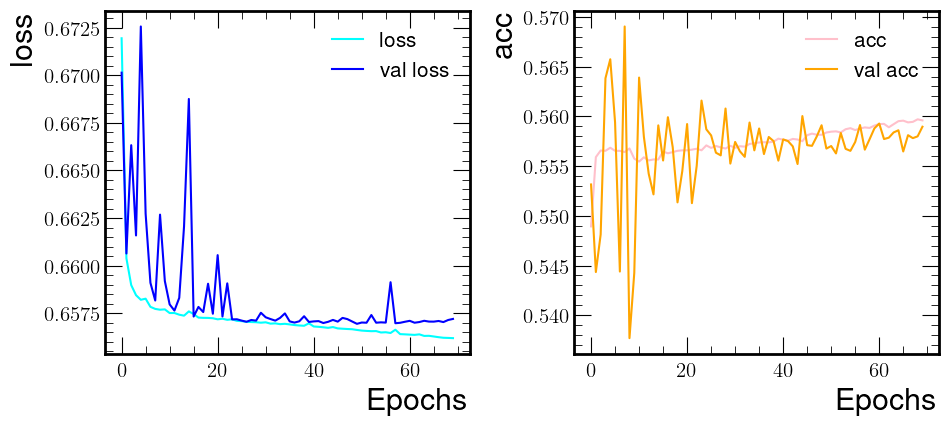

In [11]:
# CCE 4x | 7.17G VRAM
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=20, learning_rate=0.001, saveLabel='DCTR_training_np_cce_4x', loss='cce')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*4, saveLabel='DCTR_training_np_cce_4x')


Epoch 1/500
1866/1867 [============================>.] - ETA: 0s - loss: 0.6663 - acc: 0.5520
Epoch 1: val_loss improved from inf to 0.66073, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_2x.h5
1867/1867 [==============================] - 15s 7ms/step - loss: 0.6663 - acc: 0.5520 - val_loss: 0.6607 - val_acc: 0.5395 - lr: 0.0010
Epoch 2/500
1862/1867 [============================>.] - ETA: 0s - loss: 0.6590 - acc: 0.5561
Epoch 2: val_loss did not improve from 0.66073
1867/1867 [==============================] - 13s 7ms/step - loss: 0.6590 - acc: 0.5561 - val_loss: 0.6611 - val_acc: 0.5558 - lr: 0.0010
Epoch 3/500
1863/1867 [============================>.] - ETA: 0s - loss: 0.6583 - acc: 0.5562
Epoch 3: val_loss improved from 0.66073 to 0.65953, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_2x.h5
1867/1867 [==============================] - 13s 7ms/step - loss: 0.6583 - acc: 0.556

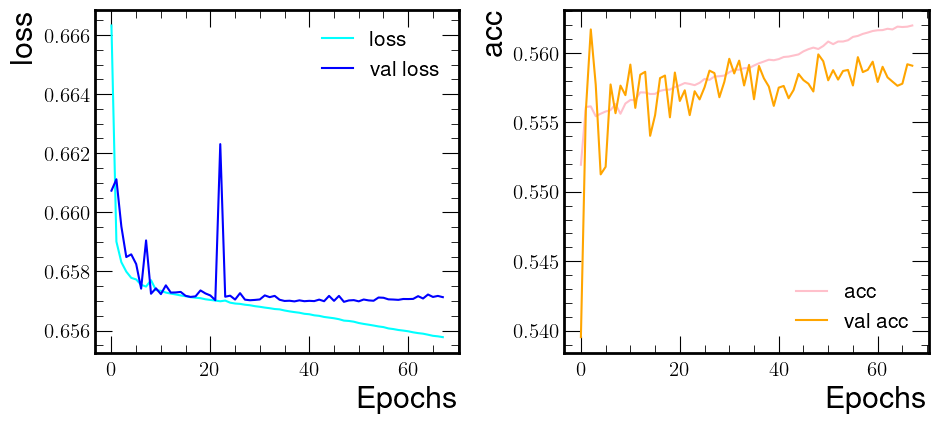

In [12]:
# CCE 2x | 7.17G VRAM
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=20, learning_rate=0.001, saveLabel='DCTR_training_np_cce_2x', loss='cce')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*2, saveLabel='DCTR_training_np_cce_2x')


Epoch 1/500
3723/3733 [============================>.] - ETA: 0s - loss: 0.6633 - acc: 0.5527
Epoch 1: val_loss improved from inf to 0.66088, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_1x.h5
3733/3733 [==============================] - 18s 5ms/step - loss: 0.6633 - acc: 0.5527 - val_loss: 0.6609 - val_acc: 0.5456 - lr: 0.0010
Epoch 2/500
3722/3733 [============================>.] - ETA: 0s - loss: 0.6585 - acc: 0.5555
Epoch 2: val_loss improved from 0.66088 to 0.65879, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_1x.h5
3733/3733 [==============================] - 17s 4ms/step - loss: 0.6585 - acc: 0.5555 - val_loss: 0.6588 - val_acc: 0.5584 - lr: 0.0010
Epoch 3/500
3727/3733 [============================>.] - ETA: 0s - loss: 0.6580 - acc: 0.5555
Epoch 3: val_loss improved from 0.65879 to 0.65790, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/D

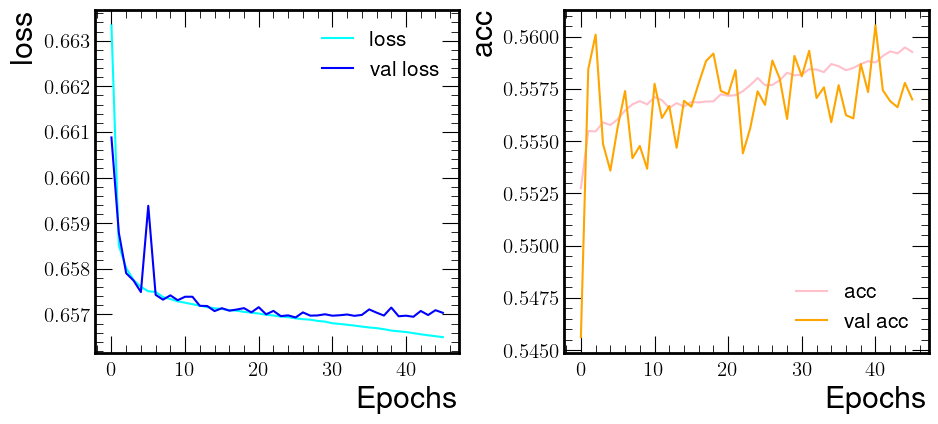

In [13]:
# CCE 1x | 7.17G VRAM
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=20, learning_rate=0.001, saveLabel='DCTR_training_np_cce_1x', loss='cce')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8192*1, saveLabel='DCTR_training_np_cce_1x')


Epoch 1/500
7462/7465 [============================>.] - ETA: 0s - loss: 0.6616 - acc: 0.5539
Epoch 1: val_loss improved from inf to 0.65887, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_0.5x.h5
7465/7465 [==============================] - 26s 3ms/step - loss: 0.6616 - acc: 0.5539 - val_loss: 0.6589 - val_acc: 0.5508 - lr: 0.0010
Epoch 2/500
7449/7465 [============================>.] - ETA: 0s - loss: 0.6581 - acc: 0.5558
Epoch 2: val_loss improved from 0.65887 to 0.65801, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_0.5x.h5
7465/7465 [==============================] - 24s 3ms/step - loss: 0.6581 - acc: 0.5558 - val_loss: 0.6580 - val_acc: 0.5512 - lr: 0.0010
Epoch 3/500
7454/7465 [============================>.] - ETA: 0s - loss: 0.6577 - acc: 0.5559
Epoch 3: val_loss improved from 0.65801 to 0.65749, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Noteboo

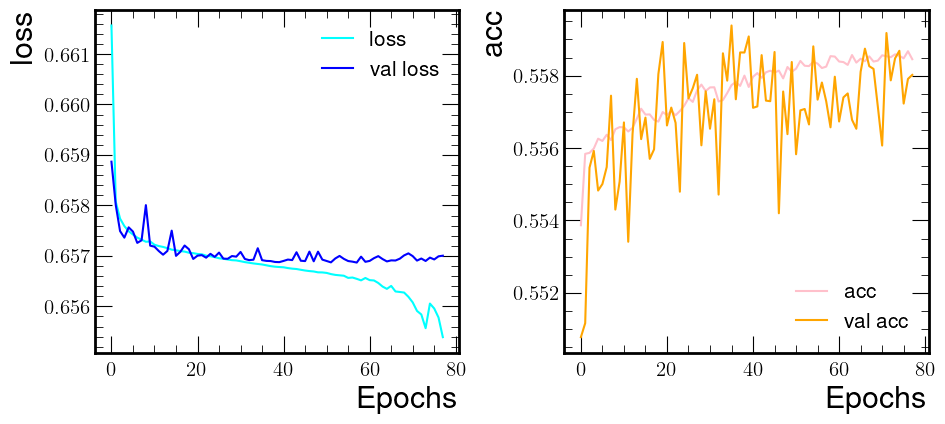

In [14]:
# CCE 0.5x | 7.17G VRAM
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=20, learning_rate=0.001, saveLabel='DCTR_training_np_cce_0.5x', loss='cce')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=4096, saveLabel='DCTR_training_np_cce_0.5x')


Epoch 1/500
465/467 [============================>.] - ETA: 0s - loss: 0.6806 - acc: 0.5453
Epoch 1: val_loss improved from inf to 0.66464, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_8x.h5
467/467 [==============================] - 13s 24ms/step - loss: 0.6805 - acc: 0.5453 - val_loss: 0.6646 - val_acc: 0.5497 - lr: 0.0010
Epoch 2/500
465/467 [============================>.] - ETA: 0s - loss: 0.6623 - acc: 0.5546
Epoch 2: val_loss improved from 0.66464 to 0.66047, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_training_np_cce_8x.h5
467/467 [==============================] - 11s 24ms/step - loss: 0.6623 - acc: 0.5546 - val_loss: 0.6605 - val_acc: 0.5519 - lr: 0.0010
Epoch 3/500
465/467 [============================>.] - ETA: 0s - loss: 0.6599 - acc: 0.5563
Epoch 3: val_loss improved from 0.66047 to 0.65951, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/DCTR_trai

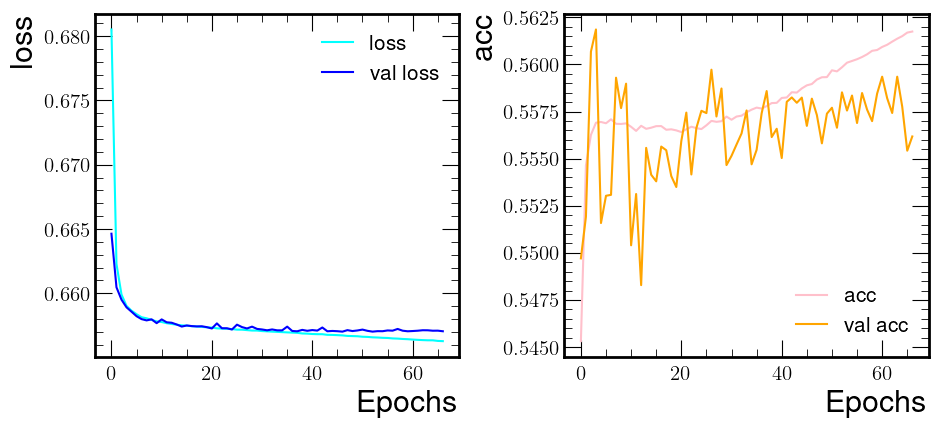

In [16]:
# CCE 8x | 7.17G VRAM
dctr, callbacks = DCTR.setup_nn(input_dim=2, Phi_sizes = (10,10,10), F_sizes = (10,10,10)) # compiling model with different sizes clears weights

# using MSE and negative event_weights
dctr, callbacks = DCTR.setup_nn(input_dim=6, dropout=0.0, l2_reg=0.0, patience=20, learning_rate=0.001, saveLabel='DCTR_training_np_cce_8x', loss='cce')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=500, batch_size=8*8192, saveLabel='DCTR_training_np_cce_8x')


# verify DCTR predictions

# load training and predict weights

In [108]:
# load training
dctr, _ = DCTR.setup_nn(input_dim = 6)
dctr.load_weights('DCTR_training.h5')


73/73 [==============================] - 11s 155ms/step


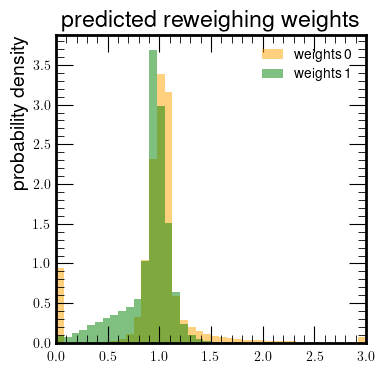

In [109]:
# get and plot reweighing weights
with tf.device('/cpu:0'): # sometimes gave me errors when done on GPU
    weights_0, weights_1 = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*16)

DCTR.plot_weights(weights_0, weights_1, start=0, stop=3, div=41)


# check and plot DCTR predictions

In [89]:
def delta_phi(X):
    phi_t = X[:,1, 2] # phi of top quark
    phi_t_bar = X[:,2, 2] # phi of anti-top quark
    delta = phi_t - phi_t_bar
    # remap delta from [-2*pi, 2*pi] to [0, 2pi]
    delta = ((delta + 2*math.pi) % (2*math.pi))
    # remap to [o, pi] since it is symmetrical
    delta = math.pi - abs(delta-math.pi)
    
    return delta


In [130]:
X0_delta_phi = delta_phi(X0_test)
X1_delta_phi = delta_phi(X1_test)


29605180out of 29605180 NLO events (100.0%) are between 0 and 3.141592653589793
9553938out of 9553938 MiNNLO events (100.0%) are between 0 and 3.141592653589793
NLO: 
 Kolmogrorov-Smirnov Distance 0.11764705882352941 with p-value p-value 0.9761919111193307 
 chi square of 35043.55509105897 with p-value 0.0 
 compared to MiNNLO
NLO reweighted: 
 Kolmogrorov-Smirnov Distance 0.058823529411764705 with p-value p-value 0.9999999993962027 
 chi square of 538.7725872062076 with p-value 9.734301930019785e-93 
 compared to MiNNLO


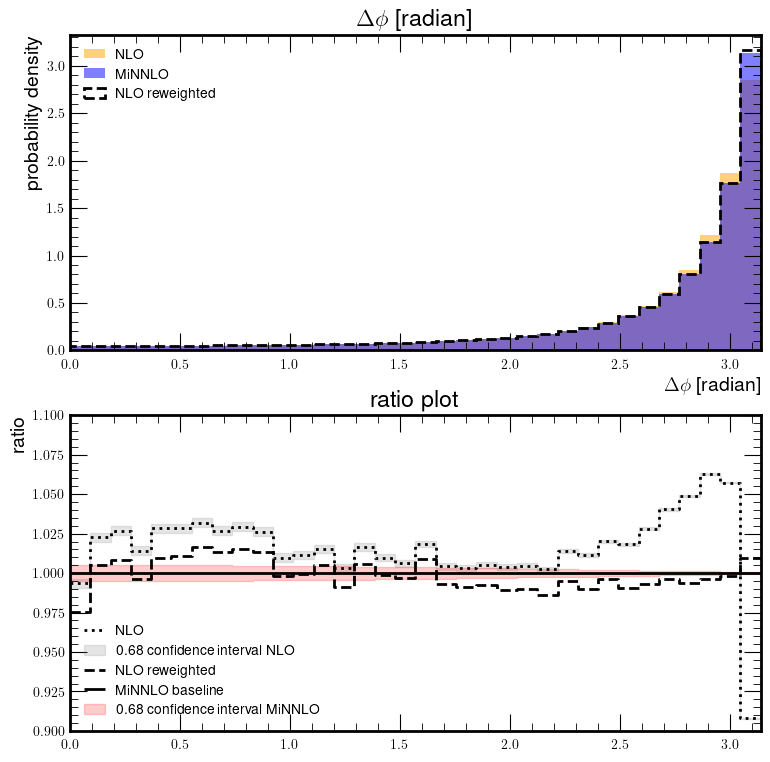

In [131]:
DCTR.plot_3_ratio_no_args(X0_delta_phi, X1_delta_phi, X0_delta_phi, title = r'$\Delta \phi$ [radian]', start=0, stop=math.pi, div = 35,
                     X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


In [ ]:
# tt-pair

29601384out of 29605180 NLO events (99.99%) are between 0 and 1000
9553348out of 9553938 MiNNLO events (99.99%) are between 0 and 1000
NLO: 
 Kolmogrorov-Smirnov Distance 0.08823529411764706 with p-value p-value 0.9996092466549565 
 chi square of 44789.71335637391 with p-value 0.0 
 compared to MiNNLO
NLO reweighted: 
 Kolmogrorov-Smirnov Distance 0.058823529411764705 with p-value p-value 0.9999999993962027 
 chi square of 96.57815293418847 with p-value 3.760062848470777e-08 
 compared to MiNNLO


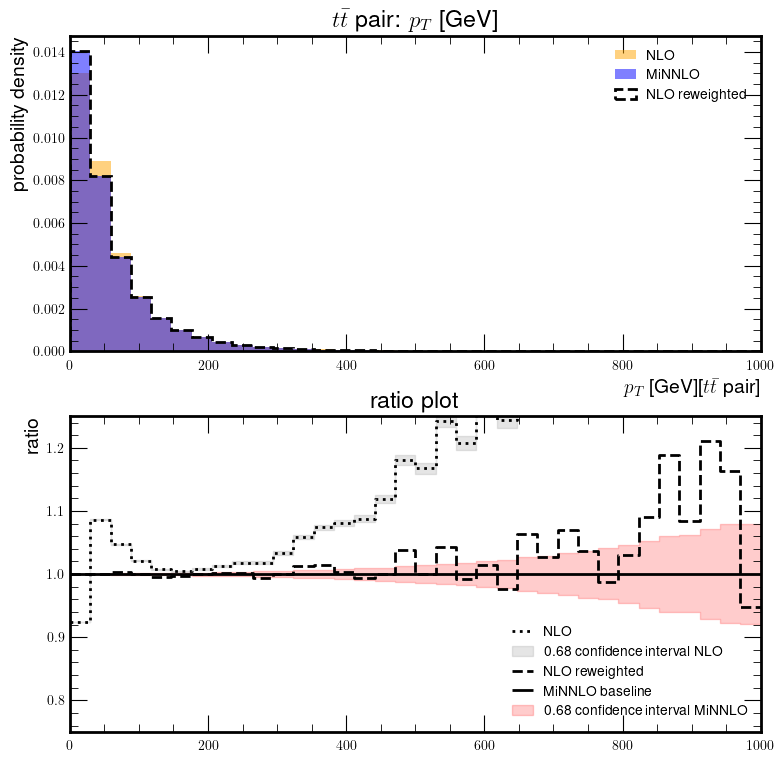

In [138]:
# pt
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 0, start=0, stop=1000, div = 35, ratio_ylim=[0.75,1.25],
                  X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


29594504out of 29605180 NLO events (99.96%) are between -8 and 8
9525643out of 9553938 MiNNLO events (99.7%) are between -8 and 8
NLO: 
 Kolmogrorov-Smirnov Distance 0.12 with p-value p-value 0.8692618870414056 
 chi square of 71249.54470640751 with p-value 0.0 
 compared to MiNNLO
NLO reweighted: 
 Kolmogrorov-Smirnov Distance 0.04 with p-value p-value 0.9999999999999891 
 chi square of 762.439043841264 with p-value 1.0551052808622381e-128 
 compared to MiNNLO


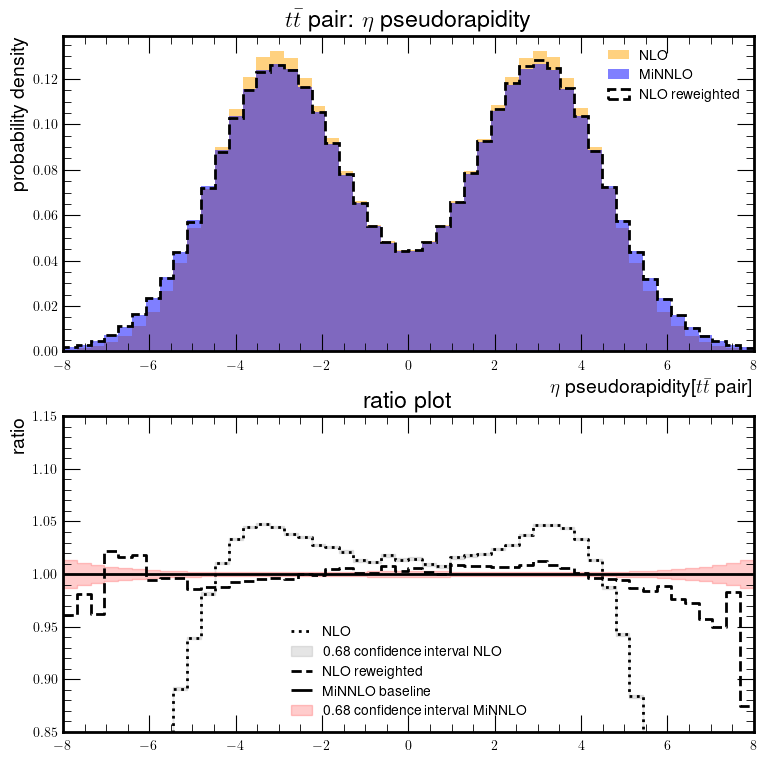

In [134]:
# eta
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 4, start=-8, stop=8, div = 35, ratio_ylim=[0.85, 1.15],
                  X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


In [114]:
# top quark

29423652out of 29605180 NLO events (99.39%) are between 0 and 450
9510411out of 9553938 MiNNLO events (99.54%) are between 0 and 450
NLO: 
 Kolmogrorov-Smirnov Distance 0.058823529411764705 with p-value p-value 0.9999999993962027 
 chi square of 12187.628833023438 with p-value 0.0 
 compared to MiNNLO
NLO reweighted: 
 Kolmogrorov-Smirnov Distance 0.058823529411764705 with p-value p-value 0.9999999993962027 
 chi square of 191.65069739505822 with p-value 2.8640075455948698e-24 
 compared to MiNNLO


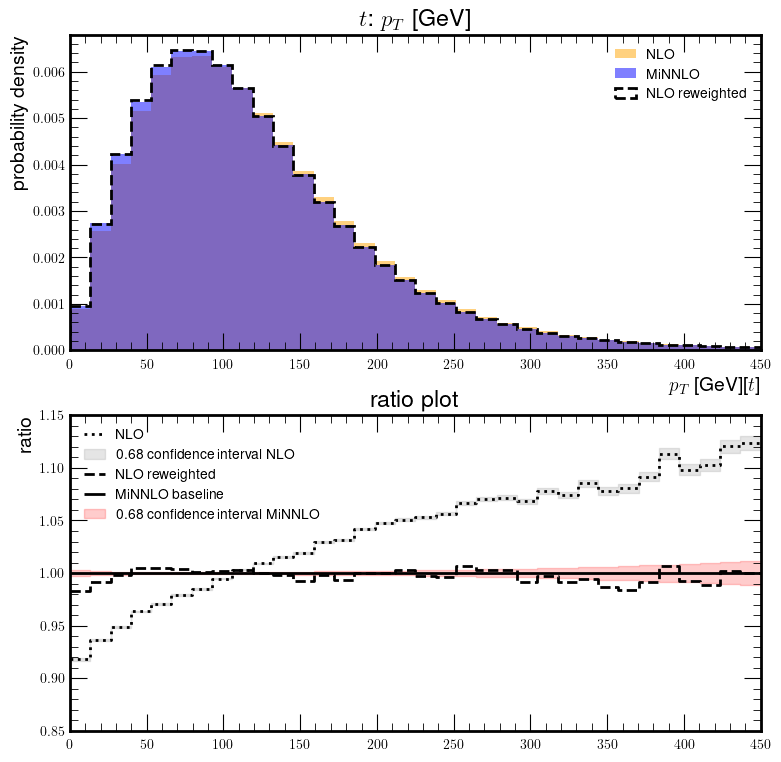

In [135]:
# pt
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 0, part_index = 1, start=0, stop=450, div = 35, ratio_ylim=[0.85, 1.15],
                  X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


28186936out of 29605180 NLO events (95.21%) are between 160 and 180
9400281out of 9553938 MiNNLO events (98.39%) are between 160 and 180
NLO: 
 Kolmogrorov-Smirnov Distance 0.20588235294117646 with p-value p-value 0.4728024347599935 
 chi square of 33556.76250376163 with p-value 0.0 
 compared to MiNNLO
NLO reweighted: 
 Kolmogrorov-Smirnov Distance 0.058823529411764705 with p-value p-value 0.9999999993962027 
 chi square of 541.1520755988892 with p-value 3.1706941456099324e-93 
 compared to MiNNLO


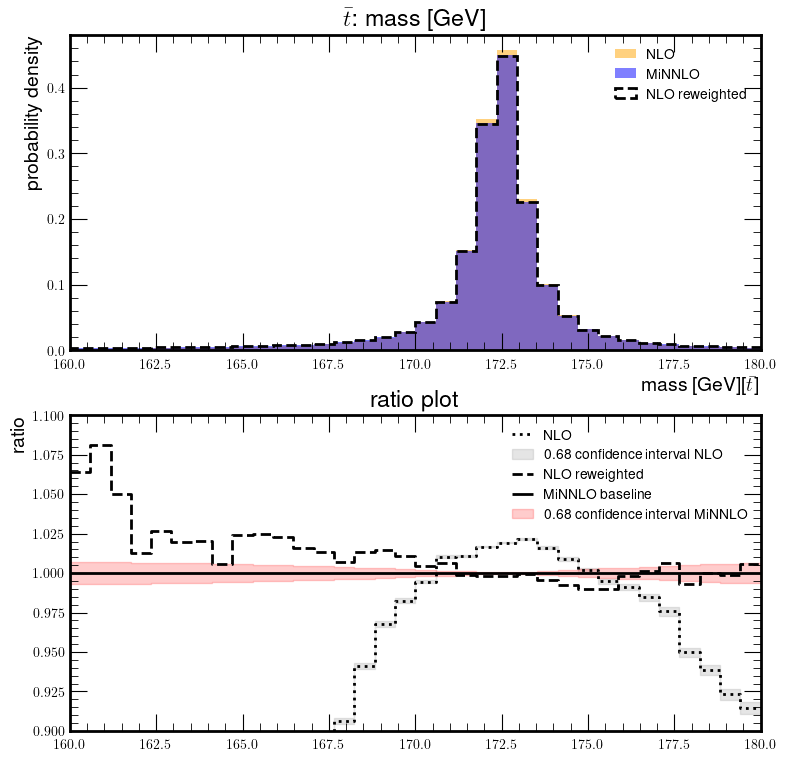

In [145]:
# mass
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 3, part_index = 2, start=160, stop=180, div = 35, ratio_ylim=[0.9, 1.1],
                  X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


In [117]:
# anti-top

29419897out of 29605180 NLO events (99.37%) are between 0 and 450
9509602out of 9553938 MiNNLO events (99.54%) are between 0 and 450
NLO: 
 Kolmogrorov-Smirnov Distance 0.058823529411764705 with p-value p-value 0.9999999993962027 
 chi square of 12415.774353810108 with p-value 0.0 
 compared to MiNNLO
NLO reweighted: 
 Kolmogrorov-Smirnov Distance 0.058823529411764705 with p-value p-value 0.9999999993962027 
 chi square of 268.5320301203327 with p-value 1.0235843000806393e-38 
 compared to MiNNLO


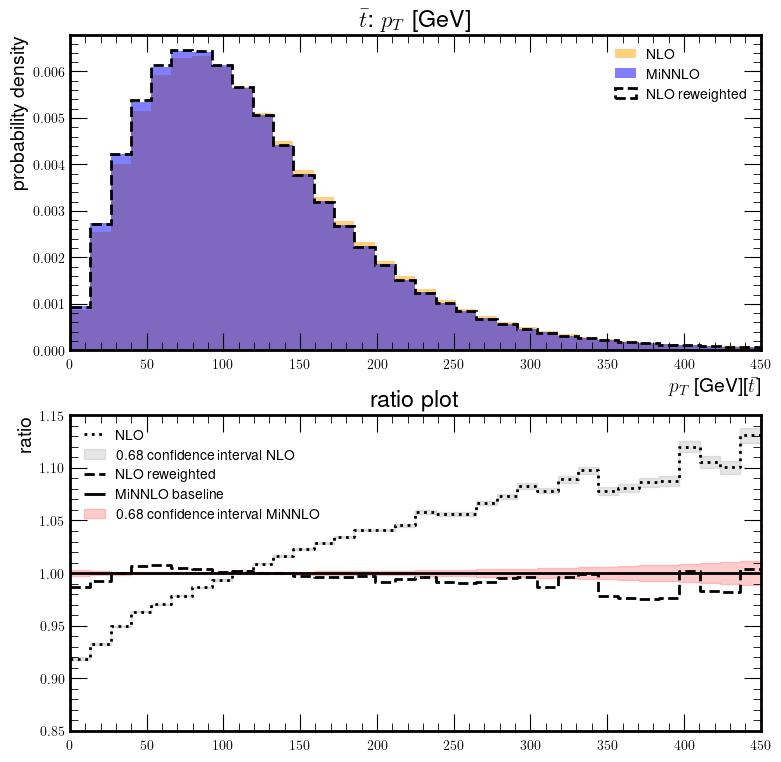

In [137]:
# pt
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 0, part_index = 2, start=0, stop=450, div = 35, ratio_ylim=[0.85, 1.15],
                  X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


28186936out of 29605180 NLO events (95.21%) are between 160 and 180
9400281out of 9553938 MiNNLO events (98.39%) are between 160 and 180
NLO: 
 Kolmogrorov-Smirnov Distance 0.2 with p-value p-value 0.2719135601522248 
 chi square of 33909.46788324813 with p-value 0.0 
 compared to MiNNLO
NLO reweighted: 
 Kolmogrorov-Smirnov Distance 0.06 with p-value p-value 0.9999952562961608 
 chi square of 559.6322189798864 with p-value 8.251274108228406e-88 
 compared to MiNNLO


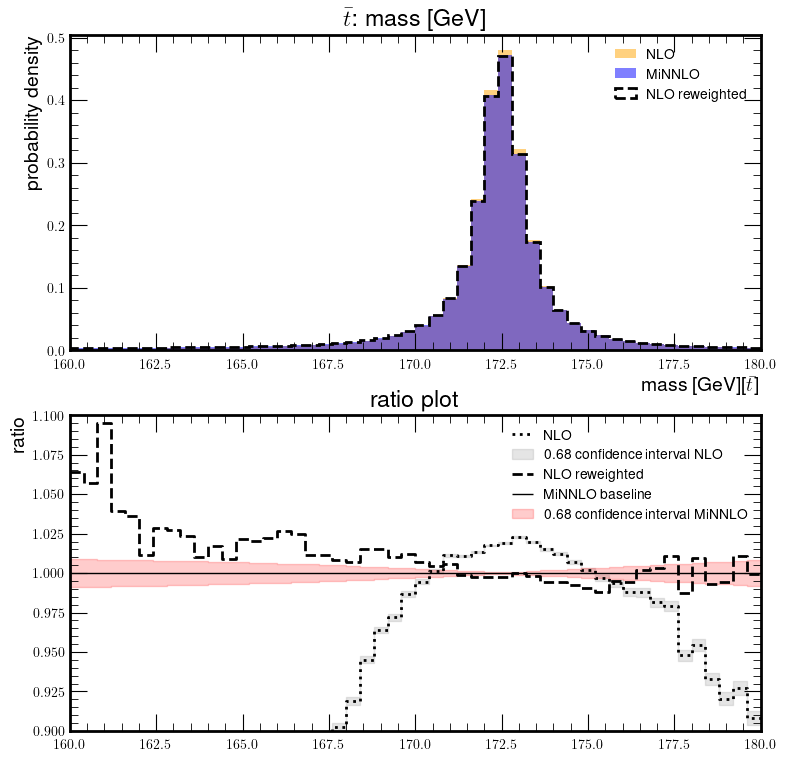

In [119]:
# mass
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 3, part_index = 2, start=160, stop=180, div = 51,
                  X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=np.array(weights_0))


In [10]:
dctr, _ = DCTR.setup_nn(input_dim = 6, loss = 'mse')
with tf.device('/cpu:0'):
    dctr.load_weights('DCTR_training_mse_16x.h5')
    weights_mse_16x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)

    dctr.load_weights('DCTR_training_mse_32x.h5')
    weights_mse_32x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)

    dctr.load_weights('DCTR_training_mse_64x.h5')
    weights_mse_64x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)


292/292 [==============================] - 10s 35ms/step


In [11]:
dctr, _ = DCTR.setup_nn(input_dim = 6)
with tf.device('/cpu:0'):

    dctr.load_weights('DCTR_training_cce_16x.h5')
    weights_cce_16x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)

    dctr.load_weights('DCTR_training_cce_32x.h5')
    weights_cce_32x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)

    dctr.load_weights('DCTR_training_cce_64x.h5')
    weights_cce_64x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)
    
    dctr.load_weights('DCTR_training_np_cce_16x.h5')
    weights_np_cce_16x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)

    dctr.load_weights('DCTR_training_np_cce_32x.h5')
    weights_np_cce_32x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)

    dctr.load_weights('DCTR_training_np_cce_64x.h5')
    weights_np_cce_64x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)
    
    dctr.load_weights('DCTR_training_np_cce_8x.h5')
    weights_np_cce_8x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)

    dctr.load_weights('DCTR_training_np_cce_4x.h5')
    weights_np_cce_4x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)

    dctr.load_weights('DCTR_training_np_cce_2x.h5')
    weights_np_cce_2x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)

    dctr.load_weights('DCTR_training_np_cce_1x.h5')
    weights_np_cce_1x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)

    dctr.load_weights('DCTR_training_np_cce_0.5x.h5')
    weights_np_cce_05x, _ = DCTR.predict_weights(dctr, X0_nrm[...,:-2], X1_nrm[...,:-2], batch_size=8192*4)



292/292 [==============================] - 10s 35ms/step


MiNNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to MiNNLO
MSE batch: 16*8192: 
 Mean Absolute Error 6386.616569010416 
 chi square of 331.4989531687471 with p 4.484362192256756e-53 
 compared to MiNNLO
MSE batch: 32*8192: 
 Mean Absolute Error 889.0420572916667 
 chi square of 20.728923516143404 with p 0.8688324910556712 
 compared to MiNNLO
MSE batch: 64*8192: 
 Mean Absolute Error 4637.708658854167 
 chi square of 191.9351264946959 with p 6.053867636966925e-26 
 compared to MiNNLO


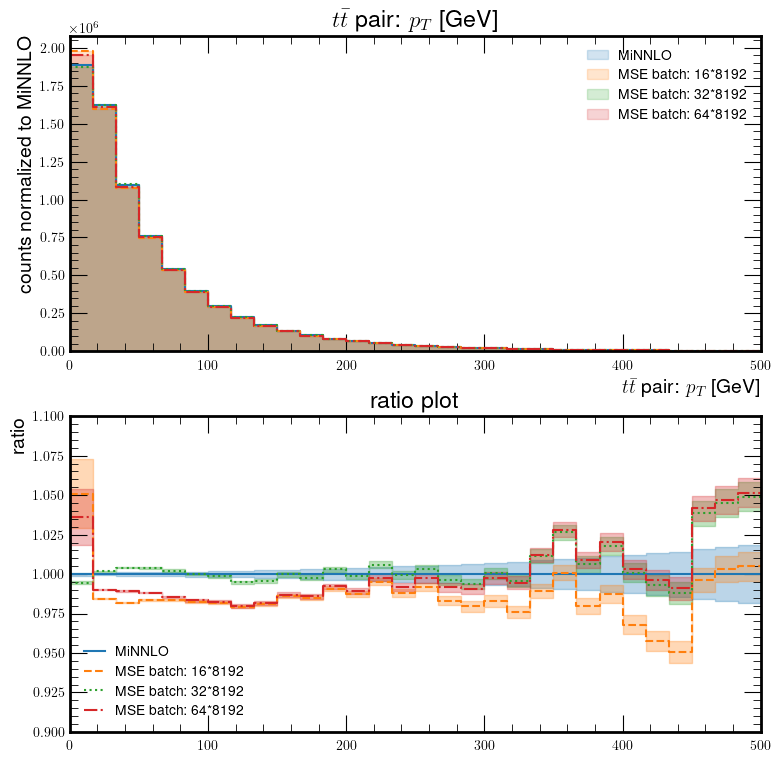

MiNNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to MiNNLO
NP CCE batch: 8*8192: 
 Mean Absolute Error 1927.4509358723958 
 chi square of 46.933827127583875 with p 0.018907312846589315 
 compared to MiNNLO
NP CCE batch: 16*8192: 
 Mean Absolute Error 1047.3637532552084 
 chi square of 24.152792551389627 with p 0.7213624077697396 
 compared to MiNNLO
NP CCE batch: 32*8192: 
 Mean Absolute Error 1874.1664388020833 
 chi square of 41.774435759279896 with p 0.05883403159539605 
 compared to MiNNLO
NP CCE batch: 64*8192: 
 Mean Absolute Error 753.9526692708333 
 chi square of 26.063843015459522 with p 0.6220768846207251 
 compared to MiNNLO


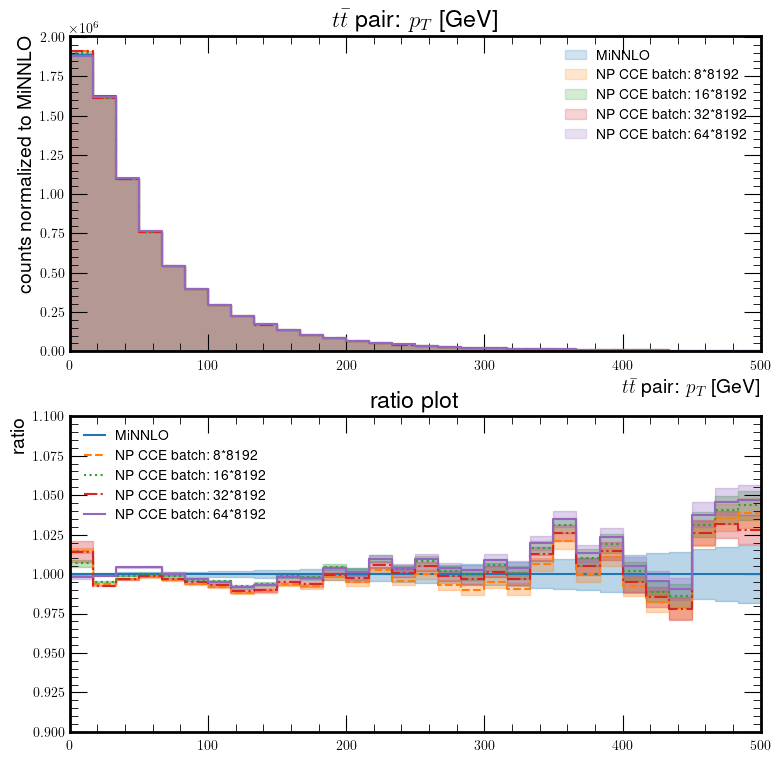

MiNNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to MiNNLO
CCE batch: 16*8192: 
 Mean Absolute Error 4171.322290039063 
 chi square of 177.17053706923093 with p 3.3467139524425036e-23 
 compared to MiNNLO
CCE batch: 32*8192: 
 Mean Absolute Error 5120.922119140625 
 chi square of 247.80639434591313 with p 1.3561294752772556e-36 
 compared to MiNNLO
CCE batch: 64*8192: 
 Mean Absolute Error 7904.2844645182295 
 chi square of 1019.413352188906 with p 6.826435754429732e-196 
 compared to MiNNLO


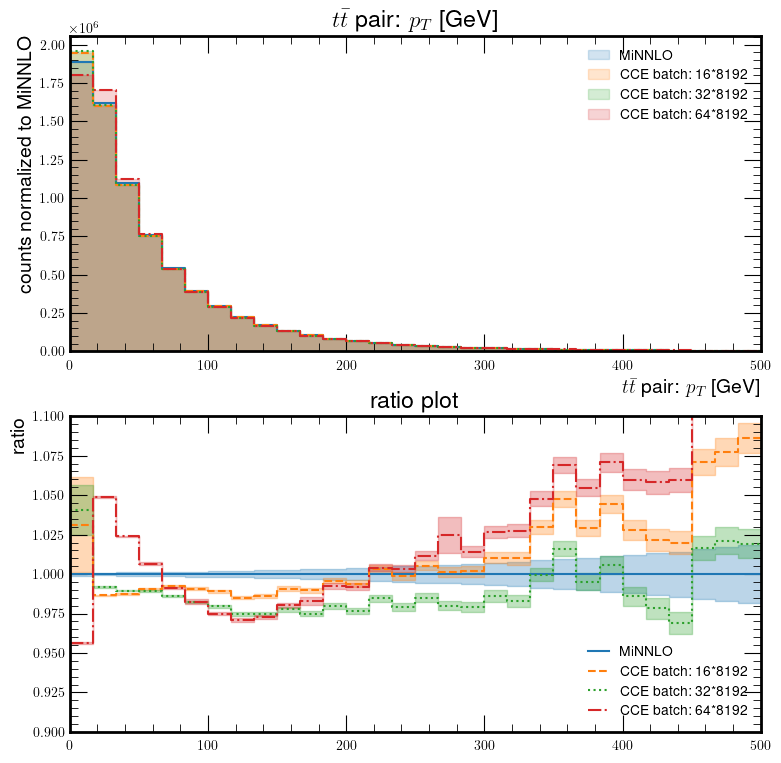

([0.0, 4171.322290039063, 5120.922119140625, 7904.2844645182295],
 [0.0, 177.17053706923093, 247.80639434591313, 1019.413352188906],
 [1.0, 3.3467139524425036e-23, 1.3561294752772556e-36, 6.826435754429732e-196])

In [31]:
args_mse = [(X1_test, X1_nrm_wgt, 'MiNNLO'),
        (X0_test, weights_mse_16x, 'MSE batch: 16*8192'),
        (X0_test, weights_mse_32x, 'MSE batch: 32*8192'),
        (X0_test, weights_mse_64x, 'MSE batch: 64*8192')]


args_np_cce = [(X1_test, X1_nrm_wgt, 'MiNNLO'),
        (X0_test, weights_np_cce_8x, 'NP CCE batch: 8*8192'),
        (X0_test, weights_np_cce_16x, 'NP CCE batch: 16*8192'),
        (X0_test, weights_np_cce_32x, 'NP CCE batch: 32*8192'),
        (X0_test, weights_np_cce_64x, 'NP CCE batch: 64*8192')]

args_cce = [(X1_test, X1_nrm_wgt, 'MiNNLO'),
        (X0_test, weights_cce_16x, 'CCE batch: 16*8192'),
        (X0_test, weights_cce_32x, 'CCE batch: 32*8192'),
        (X0_test, weights_cce_64x, 'CCE batch: 64*8192')]

DCTR.plot_ratio(args_mse, arg_index = 0, part_index = 0, start = 0, stop = 500, div = 31)
DCTR.plot_ratio(args_np_cce, arg_index = 0, part_index = 0, start = 0, stop = 500, div = 31)
DCTR.plot_ratio(args_cce, arg_index = 0, part_index = 0, start = 0, stop = 500, div = 31)


In [37]:
args_mse = [(X1_test, X1_nrm_wgt, 'MiNNLO'),
        (X0_test, weights_mse_16x, 'MSE batch: 16*8192'),
        (X0_test, weights_mse_32x, 'MSE batch: 32*8192'),
        (X0_test, weights_mse_64x, 'MSE batch: 64*8192')]

arg_indices = [0, 1, 3, 4]
part_indices = [0, 1]
div = 31

mae_all = []
chi2_all = []
p_all = []

for part_index in part_indices:
    for arg_index in arg_indices:
        bins = []
        if arg_index == 1:  # rapidity
            start = -4
            stop = 4
            bins = np.linspace(start, stop, div)
        elif arg_index == 3:  # mass
            if part_index == 0:  # tt-pair
                start = 320
                stop = 800
                bins = np.linspace(start, stop, div)
            else:
                start = 160
                stop = 180
                bins = np.linspace(start, stop, div)
        elif arg_index == 4:  # pseudorapidity
            start = -8
            stop = 8
            bins = np.linspace(start, stop, div)
        elif arg_index == 5: # energy
            if part_index == 0:  # tt-pair
                start = 350
                stop = 1300
                bins = np.linspace(start, stop, div)
            else:
                start = 150
                stop = 1000
                bins = np.linspace(start, stop, div)
        else:  # all else
            start = 0
            stop = 500
            bins = np.linspace(start, stop, div)
        
        mae_list, chi2_list, p_list = DCTR.plot_ratio(args_mse, arg_index=arg_index, part_index=part_index, bins=bins, stats_only=True)
        mae_all.append(mae_list)
        chi2_all.append(chi2_list)
        p_all.append(p_list)



MiNNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to MiNNLO
MSE batch: 16*8192: 
 Mean Absolute Error 6386.616569010416 
 chi square of 331.4989531687471 with p 4.484362192256756e-53 
 compared to MiNNLO
MSE batch: 32*8192: 
 Mean Absolute Error 889.0420572916667 
 chi square of 20.728923516143404 with p 0.8688324910556712 
 compared to MiNNLO
MSE batch: 64*8192: 
 Mean Absolute Error 4637.708658854167 
 chi square of 191.9351264946959 with p 6.053867636966925e-26 
 compared to MiNNLO
MiNNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to MiNNLO
MSE batch: 16*8192: 
 Mean Absolute Error 3663.5264299790065 
 chi square of 63.290476442765055 with p 0.00023654597381239396 
 compared to MiNNLO
MSE batch: 32*8192: 
 Mean Absolute Error 1515.274463335673 
 chi square of 90.79561726929187 with p 2.7445823638900478e-08 
 compared to MiNNLO
MSE batch: 64*8192: 
 Mean Absolute Error 3469.5082805633547 
 chi square of 79.654334274863 with p 1.3014

In [38]:
mae_mean = np.mean(mae_all, axis = 0)
chi2_mean = np.mean(chi2_all, axis = 0)
p_mean = np.mean(p_all, axis = 0)

print(f'MAE  mean: {mae_mean}\n')
print(f'chi2 mean: {chi2_mean}\n')
print(f'p    mean: {p_mean}\n')


MAE  mean: [   0.         3914.56377926 1055.95841711 3037.42522422]

chi2 mean: [ 0.         80.0061027  41.52256101 74.68894544]

p    mean: [1.         0.28690057 0.45765147 0.15204148]



In [39]:
args_np_cce = [(X1_test, X1_nrm_wgt, 'MiNNLO'),
        (X0_test, weights_np_cce_8x, 'NP CCE batch: 8*8192'),
        (X0_test, weights_np_cce_16x, 'NP CCE batch: 16*8192'),
        (X0_test, weights_np_cce_32x, 'NP CCE batch: 32*8192'),
        (X0_test, weights_np_cce_64x, 'NP CCE batch: 64*8192')]

arg_indices = [0, 1, 3, 4]
part_indices = [0, 1]
div = 31

mae_all = []
chi2_all = []
p_all = []

for part_index in part_indices:
    for arg_index in arg_indices:
        bins = []
        if arg_index == 1:  # rapidity
            start = -4
            stop = 4
            bins = np.linspace(start, stop, div)
        elif arg_index == 3:  # mass
            if part_index == 0:  # tt-pair
                start = 320
                stop = 800
                bins = np.linspace(start, stop, div)
            else:
                start = 160
                stop = 180
                bins = np.linspace(start, stop, div)
        elif arg_index == 4:  # pseudorapidity
            start = -8
            stop = 8
            bins = np.linspace(start, stop, div)
        elif arg_index == 5: # energy
            if part_index == 0:  # tt-pair
                start = 350
                stop = 1300
                bins = np.linspace(start, stop, div)
            else:
                start = 150
                stop = 1000
                bins = np.linspace(start, stop, div)
        else:  # all else
            start = 0
            stop = 500
            bins = np.linspace(start, stop, div)
        
        mae_list, chi2_list, p_list = DCTR.plot_ratio(args_np_cce, arg_index=arg_index, part_index=part_index, bins=bins, stats_only=True)
        mae_all.append(mae_list)
        chi2_all.append(chi2_list)
        p_all.append(p_list)



MiNNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to MiNNLO
NP CCE batch: 8*8192: 
 Mean Absolute Error 1927.4509358723958 
 chi square of 46.933827127583875 with p 0.018907312846589315 
 compared to MiNNLO
NP CCE batch: 16*8192: 
 Mean Absolute Error 1047.3637532552084 
 chi square of 24.152792551389627 with p 0.7213624077697396 
 compared to MiNNLO
NP CCE batch: 32*8192: 
 Mean Absolute Error 1874.1664388020833 
 chi square of 41.774435759279896 with p 0.05883403159539605 
 compared to MiNNLO
NP CCE batch: 64*8192: 
 Mean Absolute Error 753.9526692708333 
 chi square of 26.063843015459522 with p 0.6220768846207251 
 compared to MiNNLO
MiNNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to MiNNLO
NP CCE batch: 8*8192: 
 Mean Absolute Error 1506.0537666002908 
 chi square of 107.10170388647549 with p 6.93061367740168e-11 
 compared to MiNNLO
NP CCE batch: 16*8192: 
 Mean Absolute Error 1283.9854757626852 
 chi square of 111.250421419902

In [40]:
mae_mean = np.mean(mae_all, axis = 0)
chi2_mean = np.mean(chi2_all, axis = 0)
p_mean = np.mean(p_all, axis = 0)

print(f'MAE  mean: {mae_mean}\n')
print(f'chi2 mean: {chi2_mean}\n')
print(f'p    mean: {p_mean}\n')


MAE  mean: [   0.         1340.68256303 1267.31003624 1678.64455453  958.92347707]

chi2 mean: [ 0.         48.11529295 50.50000118 46.5206863  61.02147053]

p    mean: [1.         0.3758979  0.44833442 0.29523774 0.325287  ]



MiNNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to MiNNLO
POWHEG: 
 Mean Absolute Error 23896.45622687207 
 chi square of 19700.77571553914 with p 0.0 
 compared to MiNNLO
best neural positive reweight result: 
 Mean Absolute Error 753.53935546875 
 chi square of 26.035910933298805 with p 0.6235711175105618 
 compared to MiNNLO
best MSE loss with negative event weights reweight result: 
 Mean Absolute Error 888.0147135416667 
 chi square of 20.719766080698918 with p 0.8691528434824723 
 compared to MiNNLO


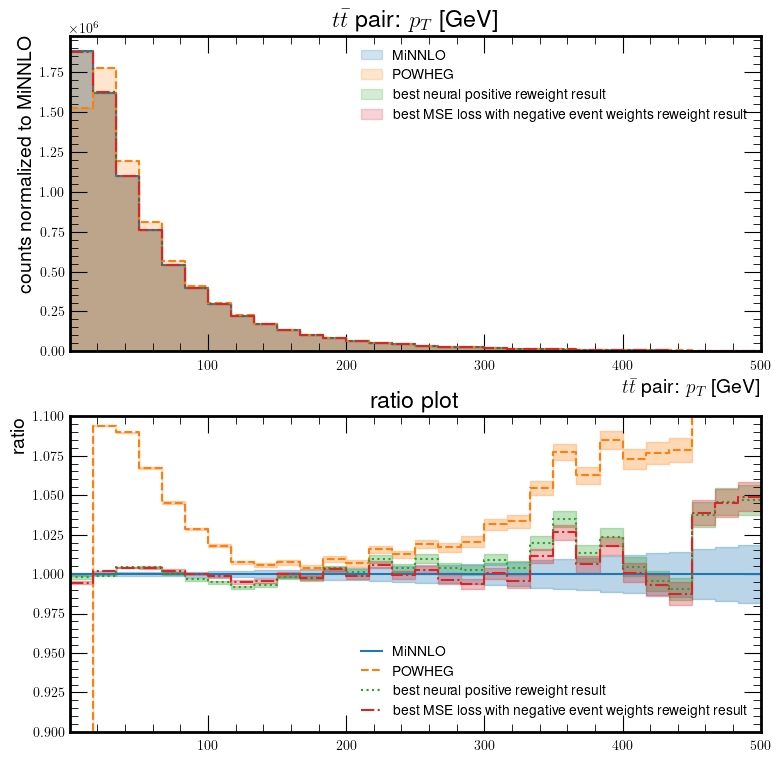

([0.0, 23896.45622687207, 753.53935546875, 888.0147135416667],
 [0.0, 19700.77571553914, 26.035910933298805, 20.719766080698918],
 [1.0, 0.0, 0.6235711175105618, 0.8691528434824723])

In [32]:
args = [(X1_test, X1_nrm_wgt, 'MiNNLO'),
        (X0_test, np.array([1.0]*len(X0_test)), 'POWHEG'),
        (X0_test, weights_np_cce_64x, 'best neural positive reweight result'),
        (X0_test, weights_mse_32x, 'best MSE loss with negative event weights reweight result')]

DCTR.plot_ratio(args, arg_index = 0, part_index = 0, stop = 500, div = 31)


In [21]:
def delta_phi(X):
    phi_t = X[:,1, 2] # phi of top quark
    phi_t_bar = X[:,2, 2] # phi of anti-top quark
    delta = phi_t - phi_t_bar
    # remap delta from [-2*pi, 2*pi] to [0, 2pi]
    delta = ((delta + 2*math.pi) % (2*math.pi))
    # remap to [0, pi] since it is symmetrical
    delta = math.pi - abs(delta-math.pi)
    
    return delta

X0_delta_phi = delta_phi(X0_test)
X1_delta_phi = delta_phi(X1_test)


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 13121.62587132097 
 chi square of 5029.022045242504 with p 0.0 
 compared to NNLO
NLO reweighted: 
 Mean Absolute Error 949.034375 
 chi square of 35.09405962859335 with p 0.20146776502010322 
 compared to NNLO


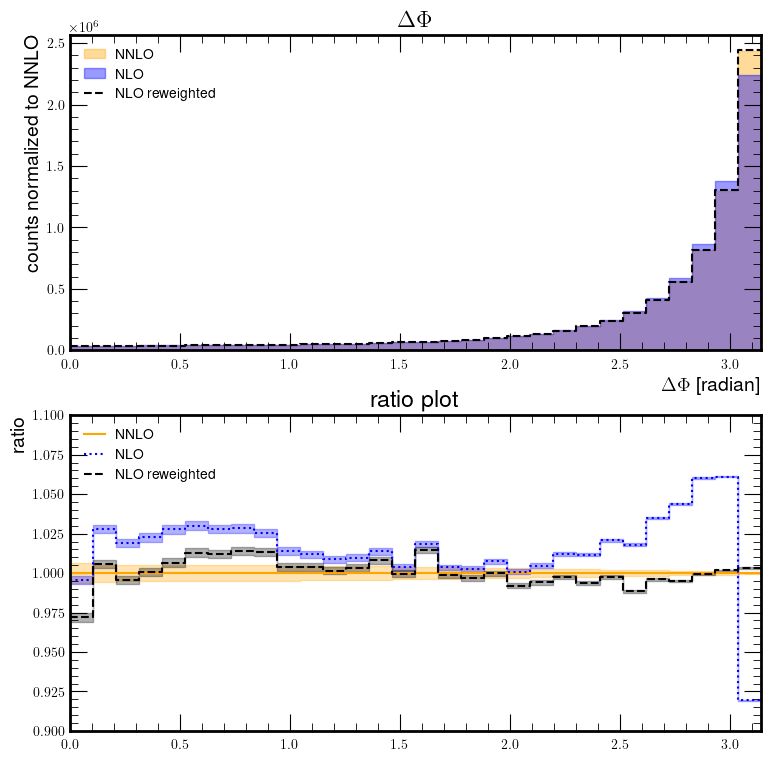

([0.0, 13121.62587132097, 949.034375],
 [0.0, 5029.022045242504, 35.09405962859335],
 [1.0, 0.0, 0.20146776502010322])

In [23]:
args_phi = [(X1_delta_phi, X1_nrm_wgt, 'NNLO'),
        (X0_delta_phi, X0_nrm_wgt, 'NLO'),
        (X0_delta_phi, weights_mse_32x, 'NLO reweighted')]

DCTR.plot_ratio(args_phi, title = r'$\Delta \Phi$', x_label = r'$\Delta \Phi$ [radian]', start = 0, stop = math.pi, div = 31)


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 13056.409751994515 
 chi square of 15285.59039806785 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 1632.369033753872 
 chi square of 214.18671945635703 with p 3.855991472794183e-30 
 compared to NNLO


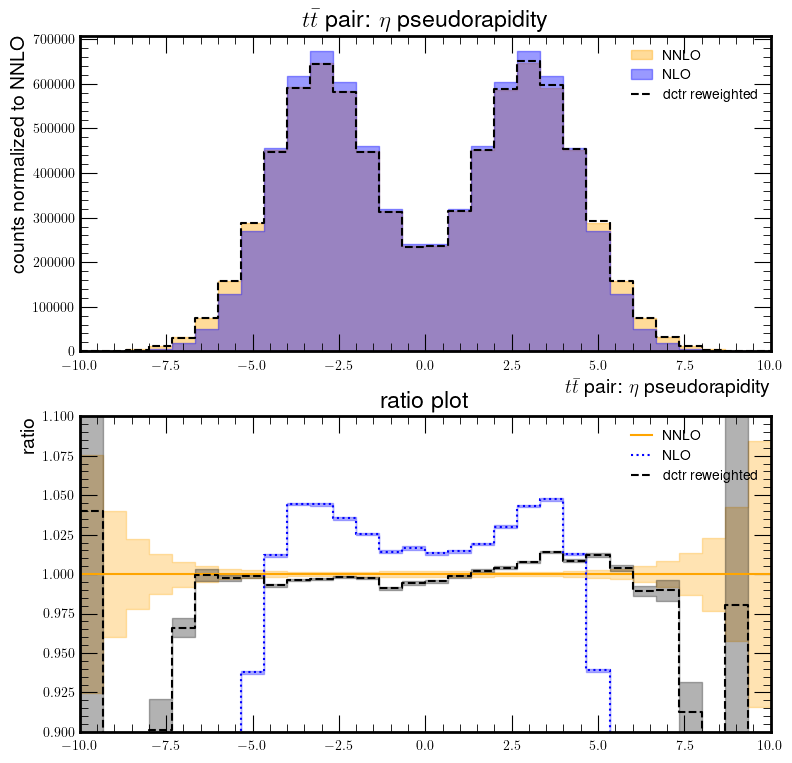

([0.0, 13056.409751994515, 1632.369033753872],
 [0.0, 15285.59039806785, 214.18671945635703],
 [1.0, 0.0, 3.855991472794183e-30])

In [49]:
# eta
args = [(X1_test, X1_nrm_wgt, 'NNLO'),
        (X0_test, X0_nrm_wgt, 'NLO'),
        (X0_test, weights_mse_32x, 'dctr reweighted')]

DCTR.plot_ratio(args, part_index=0, arg_index = 4, start = -10, stop = 10, div = 31)


/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1007: RuntimeWarning: divide by zero encountered in true_divide
  uncert_nrm = uncert/n
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1007: RuntimeWarning: invalid value encountered in true_divide
  uncert_nrm = uncert/n
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1017: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1054: RuntimeWarning: invalid value encountered in true_divide
  ratio = n/n_list[0]


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 6574.136653973105 
 chi square of 1942.5132226361964 with p 0.0 
 compared to NNLO


/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1054: RuntimeWarning: divide by zero encountered in true_divide
  ratio = n/n_list[0]


dctr reweighted: 
 Mean Absolute Error 451.97655801212085 
 chi square of 21.57098869540416 with p 0.9367436602625075 
 compared to NNLO


/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1057: RuntimeWarning: invalid value encountered in multiply
  ax2.fill_between(bins, ratio * (1 - uncert_nrm), ratio * (1 + uncert_nrm), alpha=0.3, step='post', color=ratio_color)


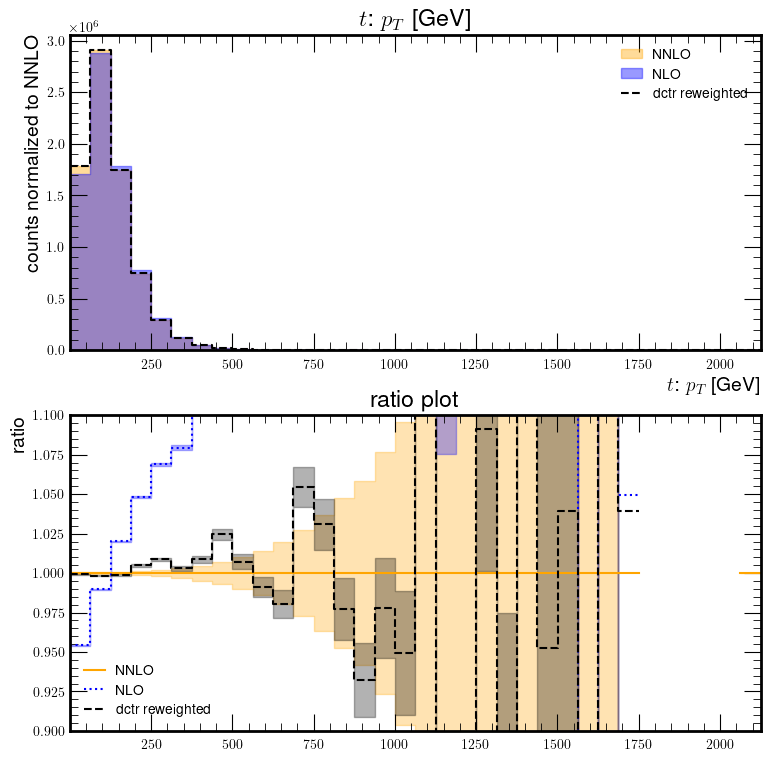

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 3134.2297412811454 
 chi square of 919.3182567109374 with p 8.710225256664687e-172 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 1050.821936950964 
 chi square of 68.58116435194627 with p 0.0002710623618152983 
 compared to NNLO


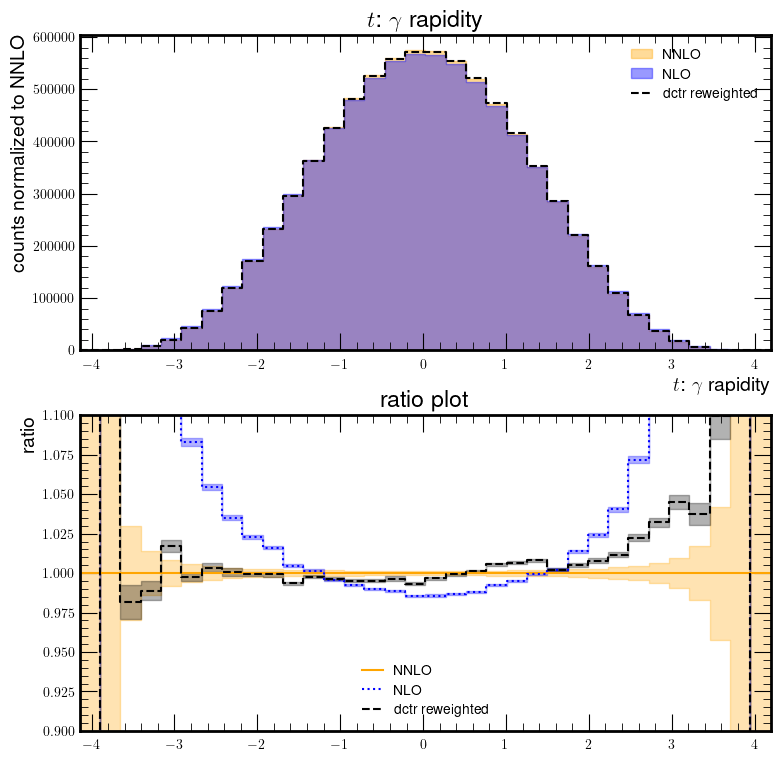

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 512.8375258919867 
 chi square of 12.677751885487686 with p 0.9994550858673896 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 587.6714154411765 
 chi square of 11.08670238783219 with p 0.9998761068101317 
 compared to NNLO


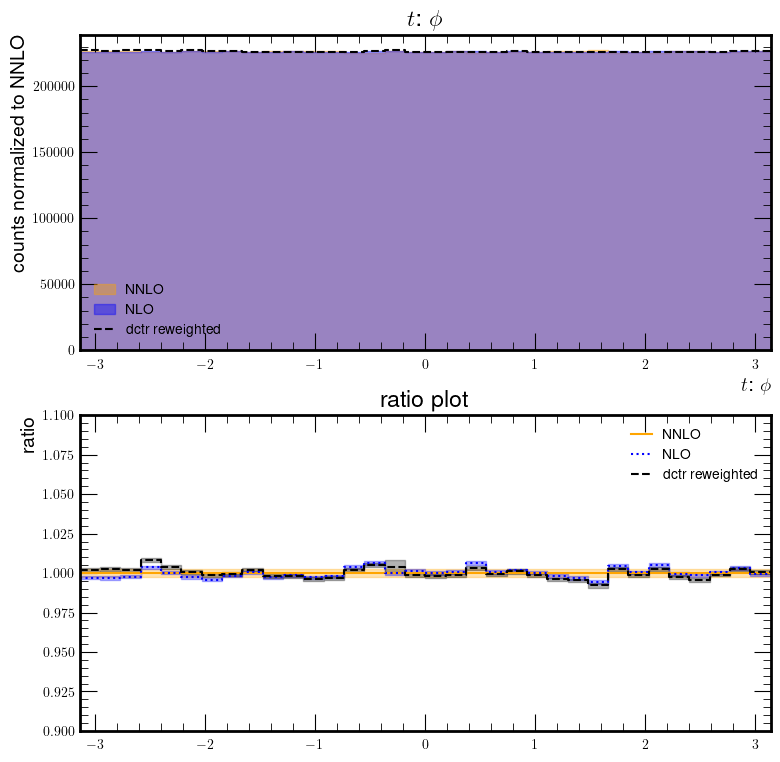

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 7624.682059055961 
 chi square of 8820.310089123677 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 542.6416733685662 
 chi square of 68.19265664307103 with p 0.00030264764777598196 
 compared to NNLO


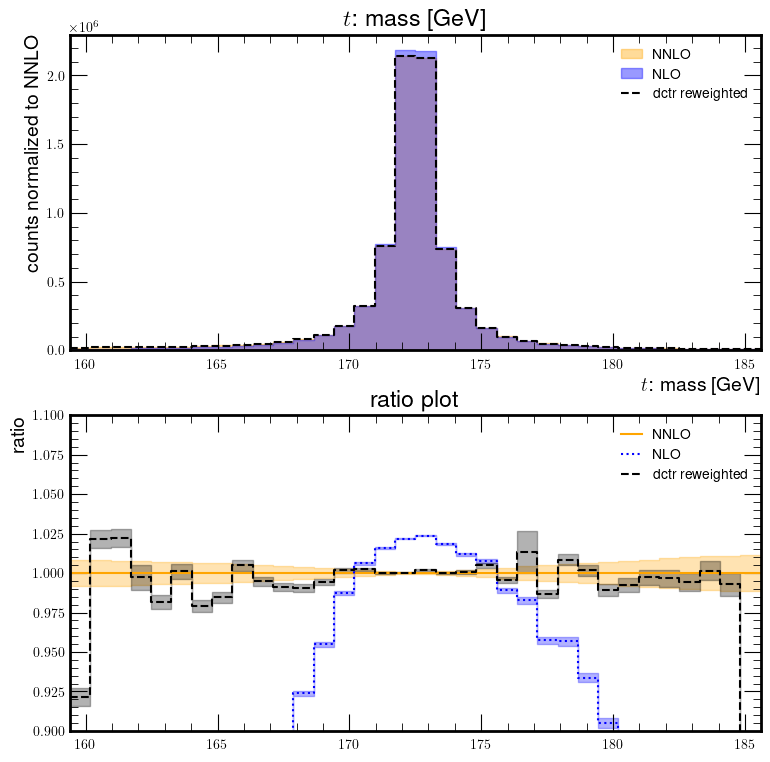

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 537.3379331928955 
 chi square of 21.799443092370797 with p 0.9319760238737695 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 1111.3903086325702 
 chi square of 38.71493277230208 with p 0.2273579462008892 
 compared to NNLO


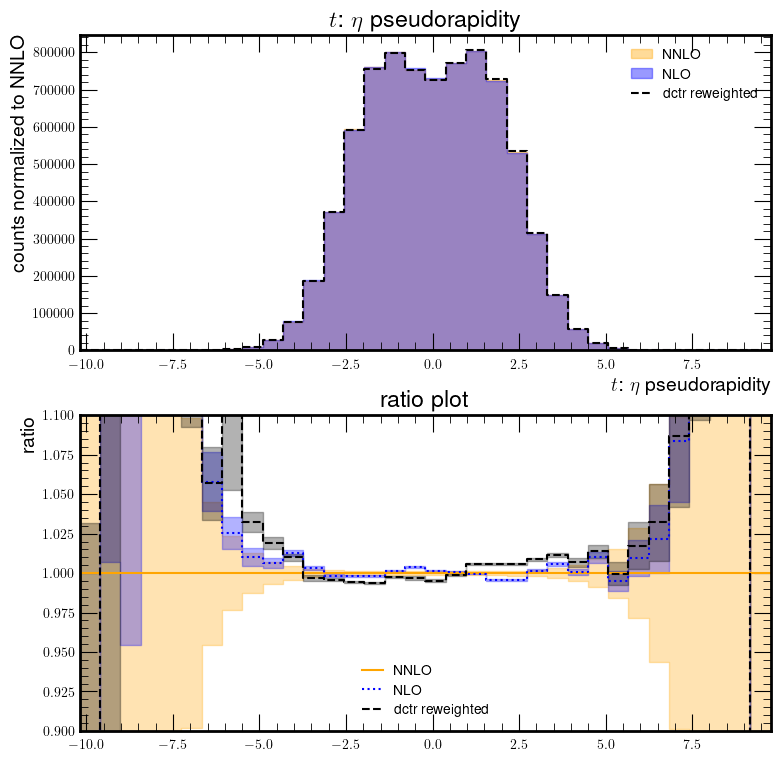

/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1007: RuntimeWarning: divide by zero encountered in true_divide
  uncert_nrm = uncert/n
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1054: RuntimeWarning: invalid value encountered in true_divide
  ratio = n/n_list[0]


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 5240.145597554575 
 chi square of 1680.1184590840219 with p 0.0 
 compared to NNLO


/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1054: RuntimeWarning: divide by zero encountered in true_divide
  ratio = n/n_list[0]


dctr reweighted: 
 Mean Absolute Error 689.5669867361294 
 chi square of 65.43091964653141 with p 0.0006539063060575237 
 compared to NNLO


/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1057: RuntimeWarning: invalid value encountered in multiply
  ax2.fill_between(bins, ratio * (1 - uncert_nrm), ratio * (1 + uncert_nrm), alpha=0.3, step='post', color=ratio_color)


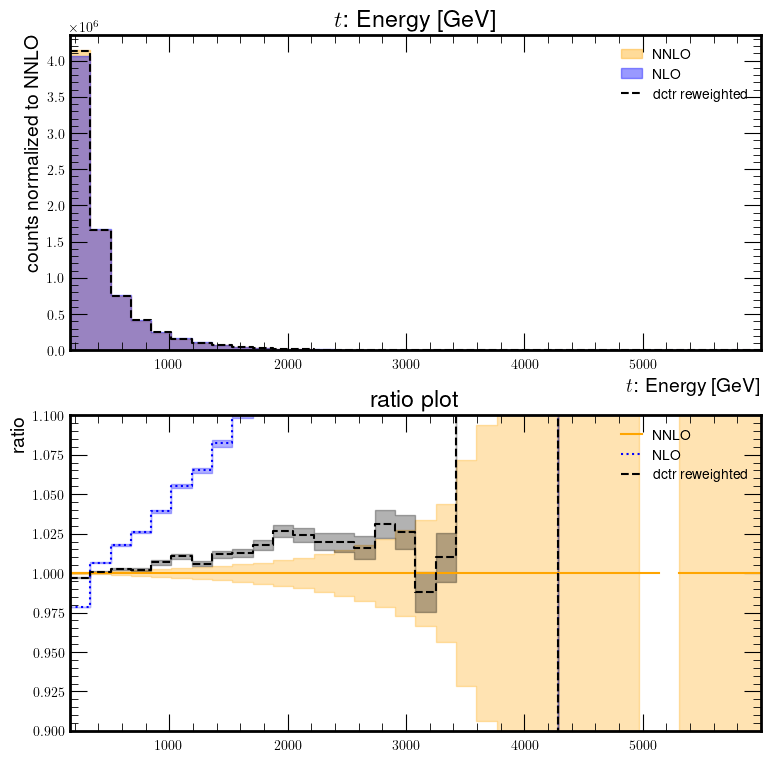

/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1007: RuntimeWarning: invalid value encountered in true_divide
  uncert_nrm = uncert/n
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1017: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.nansum(np.power(n_list[0] - n, 2)/(np.power(uncert, 2) + np.power(uncert_list[0], 2)))
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1054: RuntimeWarning: invalid value encountered in true_divide
  ratio = n/n_list[0]


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO


/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1073: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim([start, stop])
/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py:1078: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim([start, stop])


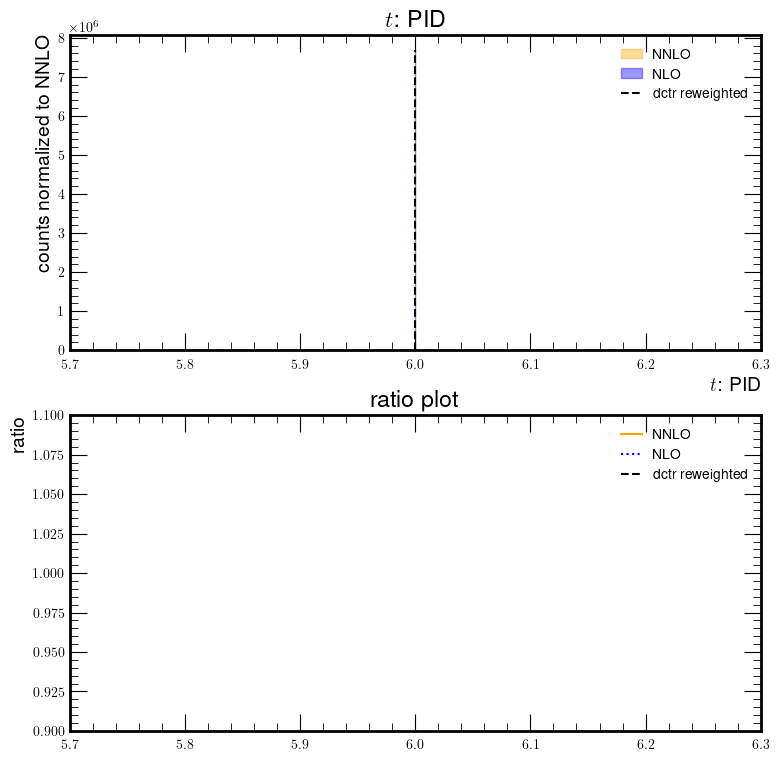

([0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [1.0, 1.0, 1.0])

In [50]:
# rapidity
args = [(X1_test, X1_nrm_wgt, 'NNLO'),
        (X0_test, X0_nrm_wgt, 'NLO'),
        (X0_test, weights_mse_32x, 'dctr reweighted')]

DCTR.plot_ratio(args, part_index=1, arg_index = 0)
DCTR.plot_ratio(args, part_index=1, arg_index = 1)
DCTR.plot_ratio(args, part_index=1, arg_index = 2)
DCTR.plot_ratio(args, part_index=1, arg_index = 3)
DCTR.plot_ratio(args, part_index=1, arg_index = 4)
DCTR.plot_ratio(args, part_index=1, arg_index = 5)
DCTR.plot_ratio(args, part_index=1, arg_index = 6)


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 7850.6128460986065 
 chi square of 8816.705554746426 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 540.4185901988636 
 chi square of 61.444471863633176 with p 0.0013258396546015157 
 compared to NNLO


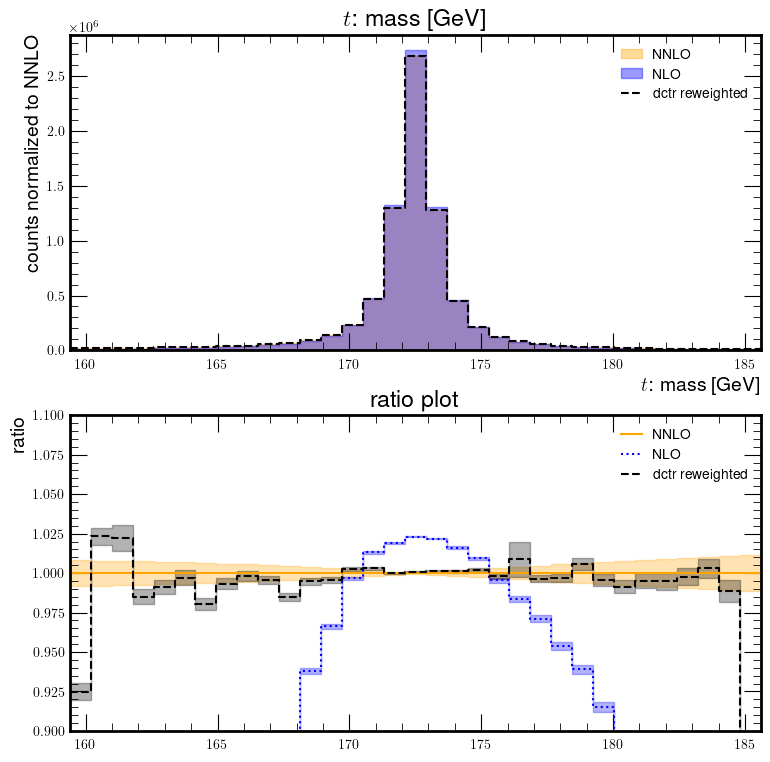

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 556.2604218017015 
 chi square of 18.96973986619882 with p 0.9757941448415403 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 1134.8174375646254 
 chi square of 41.700427459390916 with p 0.1423978683788 
 compared to NNLO


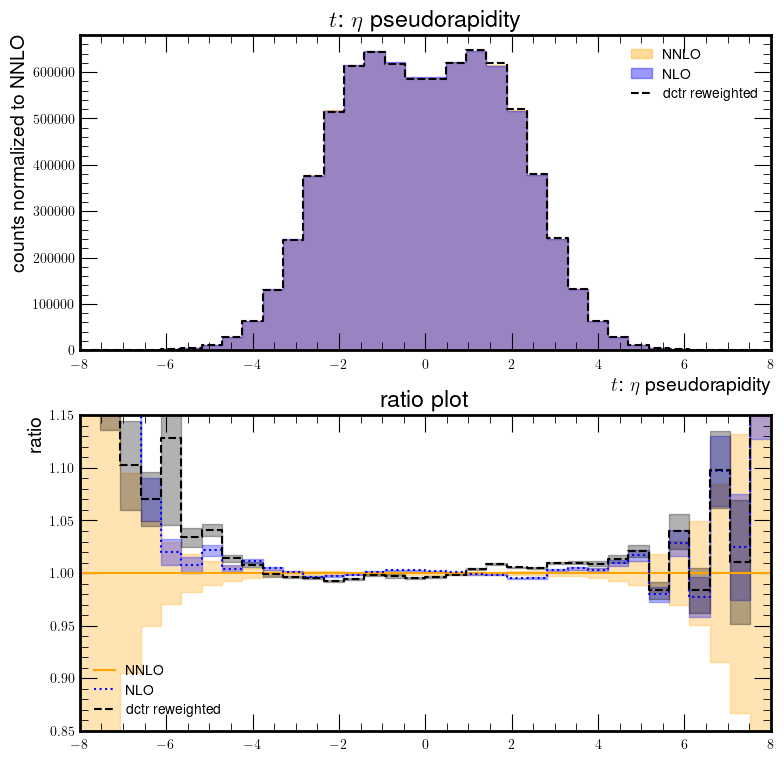

([0.0, 556.2604218017015, 1134.8174375646254],
 [0.0, 18.96973986619882, 41.700427459390916],
 [1.0, 0.9757941448415403, 0.1423978683788])

In [55]:
DCTR.plot_ratio(args, part_index=1, arg_index = 3, div = 34)
DCTR.plot_ratio(args, part_index=1, arg_index = 4, start = -8, stop = 8, ratio_ylim = [0.85, 1.15])


In [24]:
from hep_ml.reweight import BinsReweighter

bin_reweighter = BinsReweighter(n_bins=31, n_neighs=3)

bin_reweighter.fit(original=X0_test[:,0,:2], target=X1_test[:,0,:2],
               original_weight=X0_nrm_wgt, target_weight=X1_nrm_wgt)


BinsReweighter(n_bins=31, n_neighs=3)

In [25]:
bin_rwgt = bin_reweighter.predict_weights(X0_test[:,0,:2], original_weight=X0_nrm_wgt)
bin_rwgt /= np.mean(bin_rwgt) # adjust so that mean is 1


In [27]:
weights_0 = weights_mse_32x

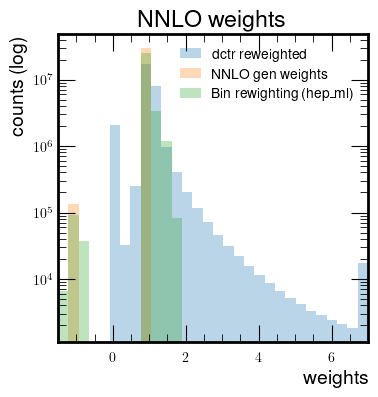

In [56]:
wgt_args = [(weights_mse_32x, 'dctr reweighted'),
            (X0_nrm_wgt, 'NNLO gen weights'),
            (bin_rwgt, 'Bin rewighting (hep_ml)')]

DCTR.plot_weights(wgt_args, title='NNLO weights', stop = 7)


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 23788.22193765147 
 chi square of 19519.687020355334 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 888.0147135416667 
 chi square of 20.719766080698918 with p 0.8691528434824723 
 compared to NNLO
bin reweighted: 
 Mean Absolute Error 4824.9817878485155 
 chi square of 721.5366697005679 with p 3.1328086048132076e-133 
 compared to NNLO


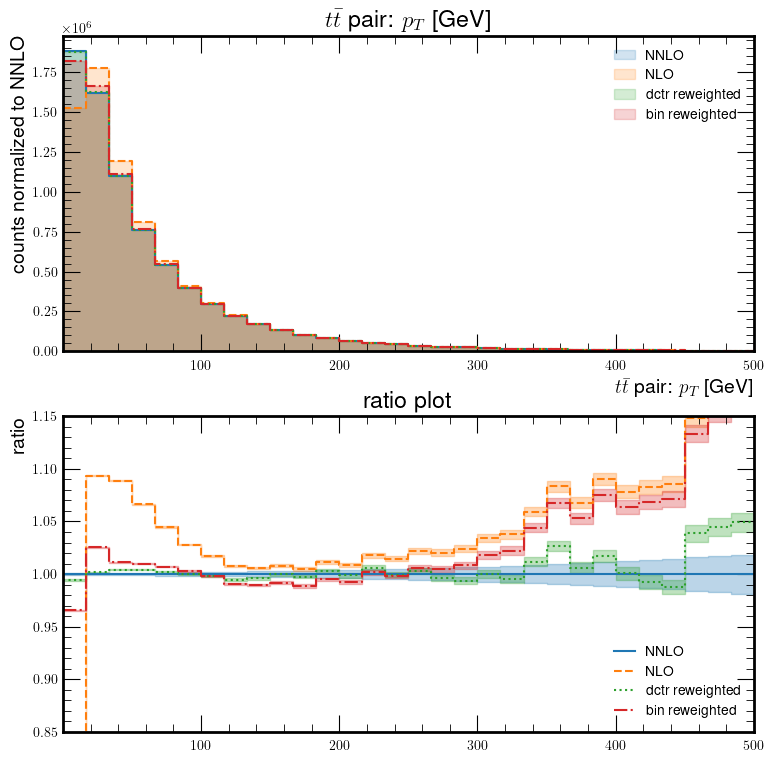

([0.0, 23788.22193765147, 888.0147135416667, 4824.9817878485155],
 [0.0, 19519.687020355334, 20.719766080698918, 721.5366697005679],
 [1.0, 0.0, 0.8691528434824723, 3.1328086048132076e-133])

In [30]:
args_comp = [(X1_test, X1_nrm_wgt, 'NNLO'),
        (X0_test, X0_nrm_wgt, 'NLO'),
        (X0_test, weights_0, 'dctr reweighted'),
        (X0_test, bin_rwgt, 'bin reweighted')]
# pt
DCTR.plot_ratio(args_comp, part_index=0, arg_index = 0, stop=500, div = 31, ratio_ylim=[0.85, 1.15])


In [59]:
arg_indices = [0, 1, 3, 4]
part_indices = [0, 1]
div = 31

mae_all = []
chi2_all = []
p_all = []

for part_index in part_indices:
    for arg_index in arg_indices:
        bins = []
        if arg_index == 1:  # rapidity
            start = -4
            stop = 4
            bins = np.linspace(start, stop, div)
        elif arg_index == 3:  # mass
            if part_index == 0:  # tt-pair
                start = 320
                stop = 800
                bins = np.linspace(start, stop, div)
            else:
                start = 160
                stop = 180
                bins = np.linspace(start, stop, div)
        elif arg_index == 4:  # pseudorapidity
            start = -8
            stop = 8
            bins = np.linspace(start, stop, div)
        elif arg_index == 5: # energy
            if part_index == 0:  # tt-pair
                start = 350
                stop = 1300
                bins = np.linspace(start, stop, div)
            else:
                start = 150
                stop = 1000
                bins = np.linspace(start, stop, div)
        else:  # all else
            start = 0
            stop = 500
            bins = np.linspace(start, stop, div)
        
        mae_list, chi2_list, p_list = DCTR.plot_ratio(args_comp, arg_index=arg_index, part_index=part_index, bins=bins, stats_only=True)
        mae_all.append(mae_list)
        chi2_all.append(chi2_list)
        p_all.append(p_list)



NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 23788.74526050928 
 chi square of 19522.230653502877 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 889.0420572916667 
 chi square of 20.728923516143404 with p 0.8688324910556712 
 compared to NNLO
bin reweighted: 
 Mean Absolute Error 4825.877914916539 
 chi square of 721.7248239930248 with p 2.8615476644235478e-133 
 compared to NNLO
NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
NLO: 
 Mean Absolute Error 5690.268471887045 
 chi square of 1931.7064178010469 with p 0.0 
 compared to NNLO
dctr reweighted: 
 Mean Absolute Error 1515.274463335673 
 chi square of 90.79561726929187 with p 2.7445823638900478e-08 
 compared to NNLO
bin reweighted: 
 Mean Absolute Error 2898.471865679797 
 chi square of 1301.3735418478923 with p 1.0876043526286625e-255 
 compared to NNLO
NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p

In [60]:
mae_mean = np.mean(mae_all, axis = 0)
chi2_mean = np.mean(chi2_all, axis = 0)
p_mean = np.mean(p_all, axis = 0)

print(f'MAE  mean: {mae_mean}\n')
print(f'chi2 mean: {chi2_mean}\n')
print(f'p    mean: {p_mean}\n')


MAE  mean: [   0.         8198.28097044 1055.95841711 4181.14056876]

chi2 mean: [   0.         6159.41370168   41.52256101 2210.05116609]

p    mean: [1.00000000e+00 1.10243230e-01 4.57651473e-01 4.58742455e-14]

